# Analysis of Global Nucleosome Positioning in *Arabidopsis thaliana*
**Author**: Emma Tung Corcoran </br>
**Date Last Modified**: April 8, 2021 </br>
**Description**: Micrococcal nuclease digestion with deep sequencing (MNase-seq) is a molecular biology technique that measures nucleosome occupancy across the whole genome. After processing paired-end MNase-seq data using the workflow here: https://github.com/etc27/MNaseseq-workflow/blob/main/README.md, a table is generated that contains nucleosome profiles across different genomic regions. The following code loads metadata from the generation of nucleosome TSS metaprofiles (profiles showing average nucleosome occupancy relative to the Transcription Start Site of genes) and performs dimensionality reduction and clustering analysis in order to learn meaningful patterns in the data. In combination with RNA sequencing (RNA-seq) data, information about global gene expression is also included in the models below to provide more information about gene features for cluster assignment. This code analyzes merged biological replicates corresponding to the same genotype.

In [1]:
#Load required dependencies
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import os
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
import community as community_louvain
import networkx as nx
import phate
import scprep
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import torch
from torch.nn.functional import softmax
from torch import optim, nn
import torchvision.transforms as transforms

## Load and Clean Data
First, I load the data generated using deeptools and clean by removing empty columns, adding columns corresponding to gene names, and subsectioning data by sample. I also take a look at the metaprofiles by plotting the sum over all genes.

In [2]:
#Load data matrices
#Profile values at each gene
base_path = "/Users/emmacorcoran/Desktop/MNase_2021_03_31/deeptools/"
filename = "mnase-merged-proteincoding.tab"
path_to_file = os.path.join(base_path, filename)
data_matrix = pd.read_csv(path_to_file, skiprows=2, sep='\t')

In [3]:
data_matrix

,Col-1.merge.140-160,Col-1.merge.140-160.1,Col-1.merge.140-160.2,Col-1.merge.140-160.3,Col-1.merge.140-160.4,Col-1.merge.140-160.5,Col-1.merge.140-160.6,Col-1.merge.140-160.7,Col-1.merge.140-160.8,Col-1.merge.140-160.9,...,R17A-2.merge.140-160.190,R17A-2.merge.140-160.191,R17A-2.merge.140-160.192,R17A-2.merge.140-160.193,R17A-2.merge.140-160.194,R17A-2.merge.140-160.195,R17A-2.merge.140-160.196,R17A-2.merge.140-160.197,R17A-2.merge.140-160.198,R17A-2.merge.140-160.199
0,0.000000,0.005970,0.008954,0.02897,0.038100,0.035290,0.033180,0.013170,0.007374,0.008252,...,0.132000,0.135500,0.102900,0.05123,0.047990,0.030570,0.023690,0.020250,0.02571,0.040290
1,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.044340,0.038670,0.043940,0.02774,0.014780,0.015190,0.016000,0.012150,0.01215,0.006884
2,0.013170,0.017560,0.015100,0.01053,0.004389,0.000000,0.000000,0.003863,0.007023,0.007023,...,0.098200,0.106500,0.062570,0.02997,0.015190,0.005669,0.025510,0.032400,0.03604,0.068640
3,0.007023,0.011590,0.016330,0.01580,0.010530,0.008954,0.005618,0.011240,0.019660,0.032660,...,0.020250,0.011340,0.012150,0.02490,0.040500,0.039080,0.036450,0.022480,0.00000,0.011140
4,0.041790,0.036520,0.043720,0.06005,0.074440,0.071810,0.079180,0.064260,0.044420,0.045120,...,0.004050,0.003442,0.000000,0.00000,0.000000,0.010120,0.016200,0.030980,0.06763,0.058920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27438,0.017030,0.021420,0.031600,0.03880,0.053370,0.045300,0.039330,0.043890,0.067770,0.080590,...,0.006277,0.004050,0.003847,0.00000,0.000000,0.000000,0.000000,0.014780,0.02025,0.037460
27439,0.000000,0.000000,0.000000,0.00000,0.000000,0.004741,0.020190,0.028090,0.029850,0.030370,...,0.023080,0.021460,0.020250,0.01660,0.009516,0.008099,0.008099,0.009314,0.02146,0.031590
27440,0.003512,0.008076,0.012290,0.01053,0.010530,0.007199,0.004916,0.010360,0.012470,0.016680,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.002227,0.013970,0.01640,0.036450
27441,0.040210,0.042490,0.060920,0.07321,0.094640,0.099380,0.076020,0.061980,0.018790,0.007023,...,0.018830,0.023890,0.030170,0.02652,0.041510,0.037050,0.045150,0.044140,0.03159,0.039280


In [4]:
#Matrix containing gene names corresponding to each row of data_matrix
base_path = "/Users/emmacorcoran/Desktop/MNase_2021_03_31/deeptools/"
filename = "mnase-merged-proteincoding.bed"
path_to_file = os.path.join(base_path, filename)
sorted_genes = pd.read_csv(path_to_file, sep='\t')
#Make dataframe containing gene names and relabel gene naming convention to correspond with RNA-seq data
gene_names = sorted_genes['name'].copy()
gene_num = len(gene_names)
for i in range(gene_num):
    newname = gene_names[i]
    if newname[0:2] == 'AT':
        gene_names[i] = newname[0:-2]

In [5]:
#Make metadata matrix (has profile values and gene names)
metadata = data_matrix.copy()
metadata['gene name'] = gene_names

In [6]:
metadata

,Col-1.merge.140-160,Col-1.merge.140-160.1,Col-1.merge.140-160.2,Col-1.merge.140-160.3,Col-1.merge.140-160.4,Col-1.merge.140-160.5,Col-1.merge.140-160.6,Col-1.merge.140-160.7,Col-1.merge.140-160.8,Col-1.merge.140-160.9,...,R17A-2.merge.140-160.191,R17A-2.merge.140-160.192,R17A-2.merge.140-160.193,R17A-2.merge.140-160.194,R17A-2.merge.140-160.195,R17A-2.merge.140-160.196,R17A-2.merge.140-160.197,R17A-2.merge.140-160.198,R17A-2.merge.140-160.199,gene name
0,0.000000,0.005970,0.008954,0.02897,0.038100,0.035290,0.033180,0.013170,0.007374,0.008252,...,0.135500,0.102900,0.05123,0.047990,0.030570,0.023690,0.020250,0.02571,0.040290,AT1G01010
1,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.038670,0.043940,0.02774,0.014780,0.015190,0.016000,0.012150,0.01215,0.006884,AT1G01020
2,0.013170,0.017560,0.015100,0.01053,0.004389,0.000000,0.000000,0.003863,0.007023,0.007023,...,0.106500,0.062570,0.02997,0.015190,0.005669,0.025510,0.032400,0.03604,0.068640,AT1G01030
3,0.007023,0.011590,0.016330,0.01580,0.010530,0.008954,0.005618,0.011240,0.019660,0.032660,...,0.011340,0.012150,0.02490,0.040500,0.039080,0.036450,0.022480,0.00000,0.011140,AT1G01040
4,0.041790,0.036520,0.043720,0.06005,0.074440,0.071810,0.079180,0.064260,0.044420,0.045120,...,0.003442,0.000000,0.00000,0.000000,0.010120,0.016200,0.030980,0.06763,0.058920,AT1G01050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27438,0.017030,0.021420,0.031600,0.03880,0.053370,0.045300,0.039330,0.043890,0.067770,0.080590,...,0.004050,0.003847,0.00000,0.000000,0.000000,0.000000,0.014780,0.02025,0.037460,AT5G67600
27439,0.000000,0.000000,0.000000,0.00000,0.000000,0.004741,0.020190,0.028090,0.029850,0.030370,...,0.021460,0.020250,0.01660,0.009516,0.008099,0.008099,0.009314,0.02146,0.031590,AT5G67610
27440,0.003512,0.008076,0.012290,0.01053,0.010530,0.007199,0.004916,0.010360,0.012470,0.016680,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.002227,0.013970,0.01640,0.036450,AT5G67620
27441,0.040210,0.042490,0.060920,0.07321,0.094640,0.099380,0.076020,0.061980,0.018790,0.007023,...,0.023890,0.030170,0.02652,0.041510,0.037050,0.045150,0.044140,0.03159,0.039280,AT5G67630


## Plot sum of all genes

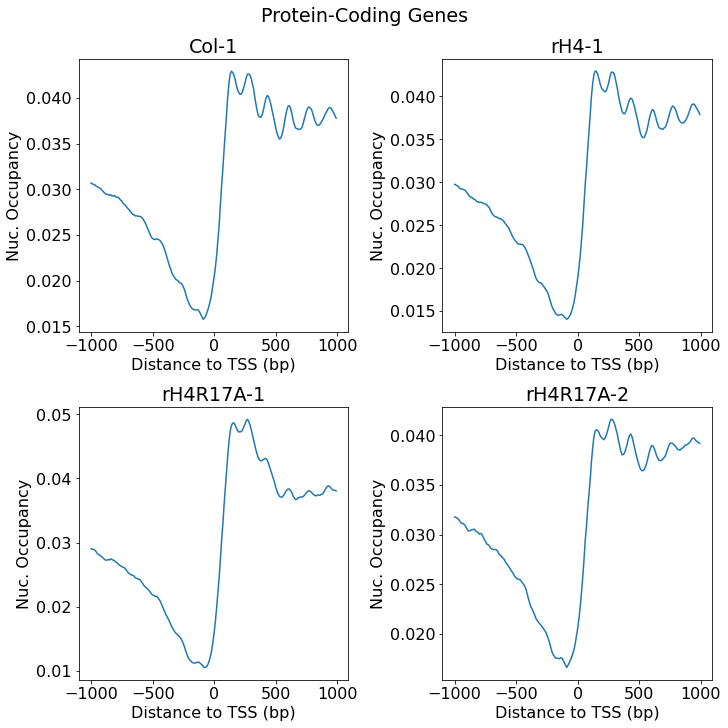

In [7]:
#Add cumulative sum of nucleosome occupancy over all genes and plot profile

#sum all rows
rowsum = data_matrix.sum(axis=0)/27443

#Split data by sample
Col_1_data = rowsum[0:200].tolist()
H4WT_1_data = rowsum[200:400].tolist()
R17A_1_data = rowsum[400:600].tolist()
R17A_2_data = rowsum[600:800].tolist()

#Plot data
plt.rcParams.update({'font.size': 16})
x_vals = np.arange(-1000,1000,10)
fig, axs = plt.subplots(2, 2, constrained_layout=True)
fig.set_size_inches(10, 10)
for ax in axs.flat:
    ax.set(xlabel='Distance to TSS (bp)', ylabel='Nuc. Occupancy')
axs[0, 0].plot(x_vals, Col_1_data)
axs[0, 0].set_title('Col-1')

axs[0, 1].plot(x_vals, H4WT_1_data)
axs[0, 1].set_title('rH4-1')

axs[1, 0].plot(x_vals, R17A_1_data)
axs[1, 0].set_title('rH4R17A-1')

axs[1, 1].plot(x_vals, R17A_2_data)
axs[1, 1].set_title('rH4R17A-2')

fig.suptitle('Protein-Coding Genes')
plt.savefig("/Users/emmacorcoran/Documents/Jupyter Code/2021_03_31_MNase/protein-coding_profiles/merged")

## Combine nucleosome positioning data with expression data from RNA-seq

In [8]:
# Subset data to only include protein coding genes (Chr1-5)
# Load protein coding gene annotation file
base_path = "/Users/emmacorcoran/Desktop/annotations"
filename = "proteincoding_1to5.txt"
path_to_file = os.path.join(base_path, filename)
proteincoding_list = pd.read_csv(path_to_file, sep='\t', header=None)
proteincoding_list.columns = ['gene name','classification']

In [9]:
# Merge metadata with protein coding list
metadata = pd.merge(metadata, proteincoding_list, on="gene name")
metadata

,Col-1.merge.140-160,Col-1.merge.140-160.1,Col-1.merge.140-160.2,Col-1.merge.140-160.3,Col-1.merge.140-160.4,Col-1.merge.140-160.5,Col-1.merge.140-160.6,Col-1.merge.140-160.7,Col-1.merge.140-160.8,Col-1.merge.140-160.9,...,R17A-2.merge.140-160.192,R17A-2.merge.140-160.193,R17A-2.merge.140-160.194,R17A-2.merge.140-160.195,R17A-2.merge.140-160.196,R17A-2.merge.140-160.197,R17A-2.merge.140-160.198,R17A-2.merge.140-160.199,gene name,classification
0,0.000000,0.005970,0.008954,0.02897,0.038100,0.035290,0.033180,0.013170,0.007374,0.008252,...,0.102900,0.05123,0.047990,0.030570,0.023690,0.020250,0.02571,0.040290,AT1G01010,protein_coding
1,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.043940,0.02774,0.014780,0.015190,0.016000,0.012150,0.01215,0.006884,AT1G01020,protein_coding
2,0.013170,0.017560,0.015100,0.01053,0.004389,0.000000,0.000000,0.003863,0.007023,0.007023,...,0.062570,0.02997,0.015190,0.005669,0.025510,0.032400,0.03604,0.068640,AT1G01030,protein_coding
3,0.007023,0.011590,0.016330,0.01580,0.010530,0.008954,0.005618,0.011240,0.019660,0.032660,...,0.012150,0.02490,0.040500,0.039080,0.036450,0.022480,0.00000,0.011140,AT1G01040,protein_coding
4,0.041790,0.036520,0.043720,0.06005,0.074440,0.071810,0.079180,0.064260,0.044420,0.045120,...,0.000000,0.00000,0.000000,0.010120,0.016200,0.030980,0.06763,0.058920,AT1G01050,protein_coding
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27438,0.017030,0.021420,0.031600,0.03880,0.053370,0.045300,0.039330,0.043890,0.067770,0.080590,...,0.003847,0.00000,0.000000,0.000000,0.000000,0.014780,0.02025,0.037460,AT5G67600,protein_coding
27439,0.000000,0.000000,0.000000,0.00000,0.000000,0.004741,0.020190,0.028090,0.029850,0.030370,...,0.020250,0.01660,0.009516,0.008099,0.008099,0.009314,0.02146,0.031590,AT5G67610,protein_coding
27440,0.003512,0.008076,0.012290,0.01053,0.010530,0.007199,0.004916,0.010360,0.012470,0.016680,...,0.000000,0.00000,0.000000,0.000000,0.002227,0.013970,0.01640,0.036450,AT5G67620,protein_coding
27441,0.040210,0.042490,0.060920,0.07321,0.094640,0.099380,0.076020,0.061980,0.018790,0.007023,...,0.030170,0.02652,0.041510,0.037050,0.045150,0.044140,0.03159,0.039280,AT5G67630,protein_coding


In [10]:
#Load RNA-seq tpm expression data
def rnaseq_load(path):
    tpm_file = pd.read_csv(path, sep='\t', header=0)
    tpm_file.columns = ['gene name','rep1','rep2']
    tpm_file['avg'] = tpm_file[['rep1', 'rep2']].mean(axis=1)
    tpm_file = tpm_file.sort_values(by=['gene name'])
    return tpm_file

In [11]:
base_path = "/Users/emmacorcoran/Documents/R Scripts/RNA-seq/2020_10_02 RNA-seq/tpm/ordered_tpm_avg/"

#Load Col expression data
filename = "Col_ordered_tpm.txt"
path_to_file = os.path.join(base_path, filename)
Col_tpm = rnaseq_load(path_to_file)

#Load H4WT expression data
filename = "H4WT_ordered_tpm.txt"
path_to_file = os.path.join(base_path, filename)
H4WT_tpm = rnaseq_load(path_to_file)

#Load H4R17A expression data
filename = "R17A_ordered_tpm.txt"
path_to_file = os.path.join(base_path, filename)
R17A_tpm = rnaseq_load(path_to_file)

In [12]:
#Merge metadata with tpm expression data and subset for one sample, plot expression groups
def rowsum_tpm(all_data, tpm_label):
    tpm_data = all_data.loc[all_data['expression category'] == tpm_label]
    tpm_data = tpm_data.iloc[:,0:200]
    nrow = tpm_data.shape[0]
    tpm_rowsum = np.array(tpm_data.sum(axis=0))/nrow
    return tpm_rowsum

In [13]:
def tpm_expression_4groups(metadata_df, tpm_data, sample_colstart, sample_colend, name):
    #Merge metadata with tpm expression data and subset for one sample
    all_data = pd.merge(metadata_df, tpm_data, on="gene name")
    subset_data = all_data.loc[:,sample_colstart:sample_colend]
    subset_data['gene name'] = all_data['gene name']
    subset_data['expression'] = all_data['avg']

    ### Add column to metadata with gene groups
    # Make gene groups and count number of genes in each group
    high_tpm = (subset_data['expression']>=2.5)
    print('Very high expression: ' + str(np.count_nonzero(high_tpm)))
    medhigh_tpm = ((subset_data['expression']>=0.5) & (subset_data['expression']<2.5))
    print('High expression: ' + str(np.count_nonzero(medhigh_tpm)))
    medlow_tpm = ((subset_data['expression']>0) & (subset_data['expression']<0.5))
    print('Low expression: ' + str(np.count_nonzero(medlow_tpm)))
    low_tpm = (subset_data['expression']==0)
    print('Very low expression: ' + str(np.count_nonzero(low_tpm)))

    # Add expression category column to metadata and fill in with values
    n = len(subset_data['expression'])
    subset_data['expression category'] = ["NA"] * n
    subset_data.loc[high_tpm==True, ['expression category']] = "very high"
    subset_data.loc[medhigh_tpm==True, ['expression category']] = "high"
    subset_data.loc[medlow_tpm==True, ['expression category']] = "low"
    subset_data.loc[low_tpm==True, ['expression category']] = "very low"
    
    #Sum rows of different tpm groups
    high_rowsum = rowsum_tpm(subset_data, "very high")
    medhigh_rowsum = rowsum_tpm(subset_data, "high")
    medlow_rowsum = rowsum_tpm(subset_data, "low")
    low_rowsum = rowsum_tpm(subset_data, "very low")
    
    #Produce nucleosome occupancy plots of tpm expression groups
    plt.rcParams.update({'font.size': 16})
    x_vals = np.arange(-1000,1000,10)
    fig, axs = plt.subplots(1, 4, constrained_layout=True)
    fig.set_size_inches(15, 5)
    for ax in axs.flat:
        ax.set(xlabel='Distance to TSS (bp)', ylabel='Nuc. Occupancy')
    axs[3].plot(x_vals, high_rowsum, 'tab:red')
    axs[3].set_title('Very High')
    axs[2].plot(x_vals, medhigh_rowsum, 'tab:orange')
    axs[2].set_title("High")
    axs[1].plot(x_vals, medlow_rowsum, 'tab:green')
    axs[1].set_title("Low")
    axs[0].plot(x_vals, low_rowsum, 'tab:blue')
    axs[0].set_title("Very Low")
    
    fig.suptitle(name)
    plt.savefig("/Users/emmacorcoran/Documents/Jupyter Code/2021_03_31_MNase/tpm_profiles_4groups/merged"+name)
    
    return subset_data

In [14]:
def tpm_expression_2groups(metadata_df, tpm_data, sample_colstart, sample_colend, name):
    #Merge metadata with tpm expression data and subset for one sample
    all_data = pd.merge(metadata_df, tpm_data, on="gene name")
    subset_data = all_data.loc[:,sample_colstart:sample_colend]
    subset_data['gene name'] = all_data['gene name']
    subset_data['expression'] = all_data['avg']

    ### Add column to metadata with gene groups
    # Make gene groups and count number of genes in each group
    high_tpm = (subset_data['expression']>=0.02)
    print('High expression: ' + str(np.count_nonzero(high_tpm)))
    low_tpm = (subset_data['expression']<0.02)
    print('Low expression: ' + str(np.count_nonzero(low_tpm)))

    # Add expression category column to metadata and fill in with values
    n = len(subset_data['expression'])
    subset_data['expression category'] = ["NA"] * n
    subset_data.loc[high_tpm==True, ['expression category']] = "high"
    subset_data.loc[low_tpm==True, ['expression category']] = "low"
    
    #Sum rows of different tpm groups
    high_rowsum = rowsum_tpm(subset_data, "high")
    low_rowsum = rowsum_tpm(subset_data, "low")
    
    #Produce nucleosome occupancy plots of tpm expression groups
    plt.rcParams.update({'font.size': 16})
    x_vals = np.arange(-1000,1000,10)
    fig, axs = plt.subplots(1, 2, constrained_layout=True)
    fig.set_size_inches(10, 5)
    for ax in axs.flat:
        ax.set(xlabel='Distance to TSS (bp)', ylabel='Nuc. Occupancy')
    axs[1].plot(x_vals, high_rowsum, color='red')
    axs[1].set_title("High")
    axs[0].plot(x_vals, low_rowsum, color='blue')
    axs[0].set_title("Low")
    
    fig.suptitle(name)
    plt.savefig("/Users/emmacorcoran/Documents/Jupyter Code/2021_03_31_MNase/tpm_profiles_2groups/merged"+name)
    
    return subset_data

Very high expression: 9303
High expression: 6314
Low expression: 5881
Very low expression: 5945
High expression: 20484
Low expression: 6959


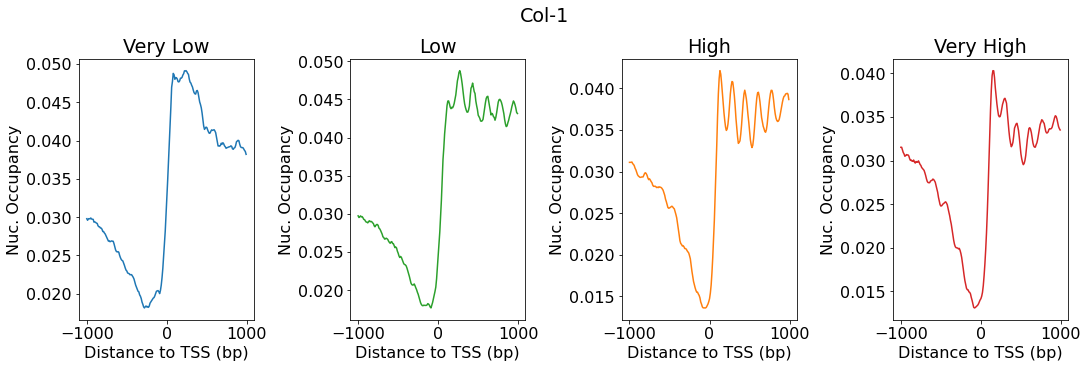

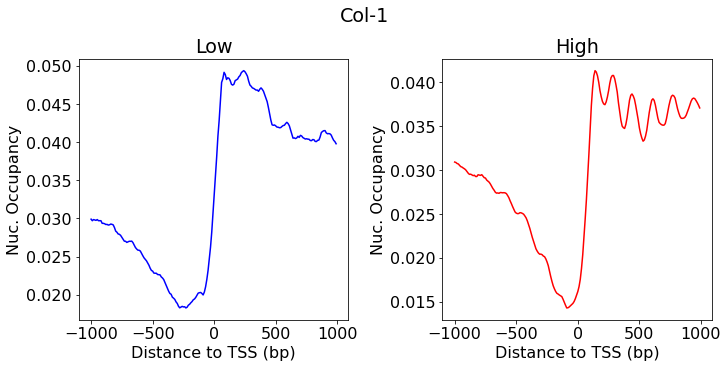

In [15]:
Col1_4subset = tpm_expression_4groups(metadata, Col_tpm, "Col-1.merge.140-160","Col-1.merge.140-160.199", "Col-1")
Col1_2subset = tpm_expression_2groups(metadata, Col_tpm, "Col-1.merge.140-160","Col-1.merge.140-160.199", "Col-1")

Very high expression: 7031
High expression: 7201
Low expression: 6710
Very low expression: 6501
High expression: 19852
Low expression: 7591


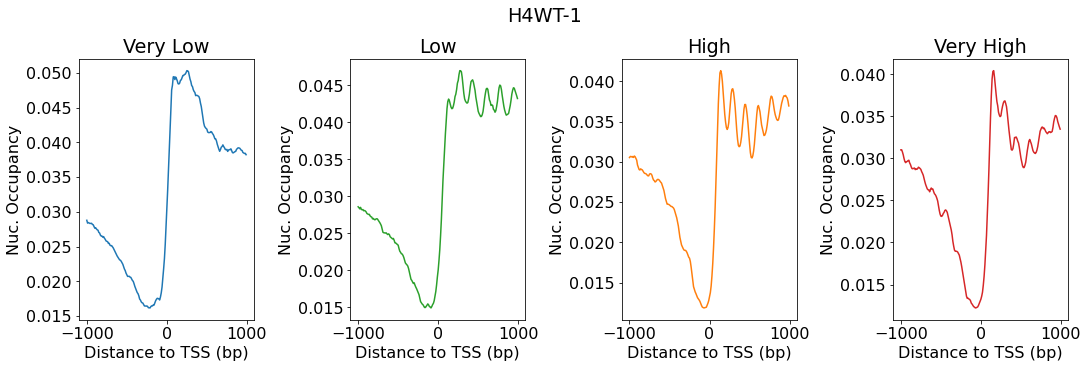

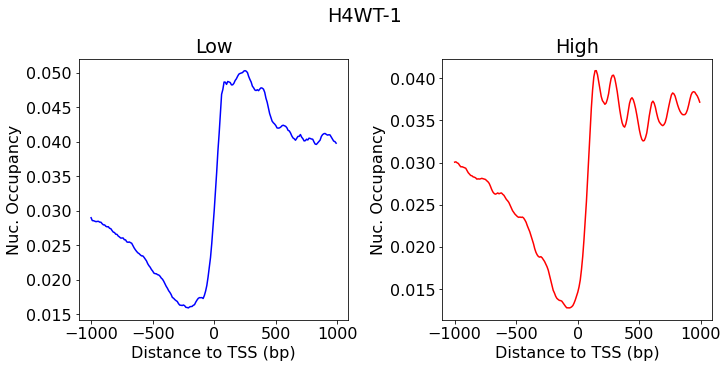

In [16]:
H4WT1_4subset = tpm_expression_4groups(metadata, H4WT_tpm, "H4WT-1.merge.140-160","H4WT-1.merge.140-160.199", "H4WT-1")
H4WT1_2subset = tpm_expression_2groups(metadata, H4WT_tpm, "H4WT-1.merge.140-160","H4WT-1.merge.140-160.199", "H4WT-1")

Very high expression: 8701
High expression: 6516
Low expression: 6198
Very low expression: 6028
High expression: 20257
Low expression: 7186


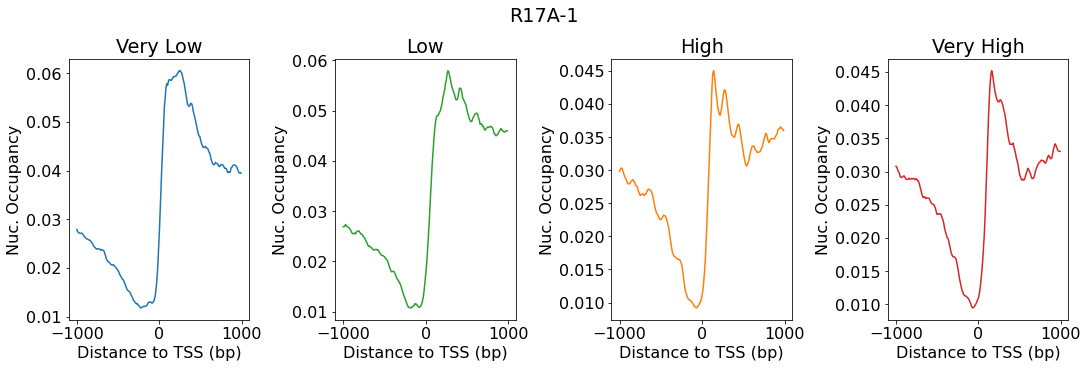

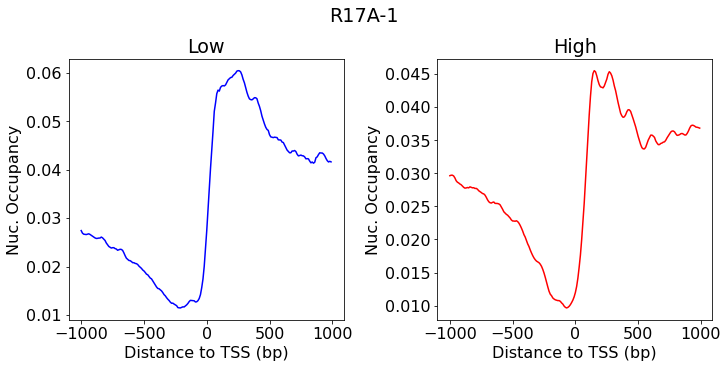

In [17]:
R17A1_4subset = tpm_expression_4groups(metadata, R17A_tpm, "R17A-1.merge.140-160","R17A-1.merge.140-160.199", "R17A-1")
R17A1_2subset = tpm_expression_2groups(metadata, R17A_tpm, "R17A-1.merge.140-160","R17A-1.merge.140-160.199", "R17A-1")

Very high expression: 8701
High expression: 6516
Low expression: 6198
Very low expression: 6028
High expression: 20257
Low expression: 7186


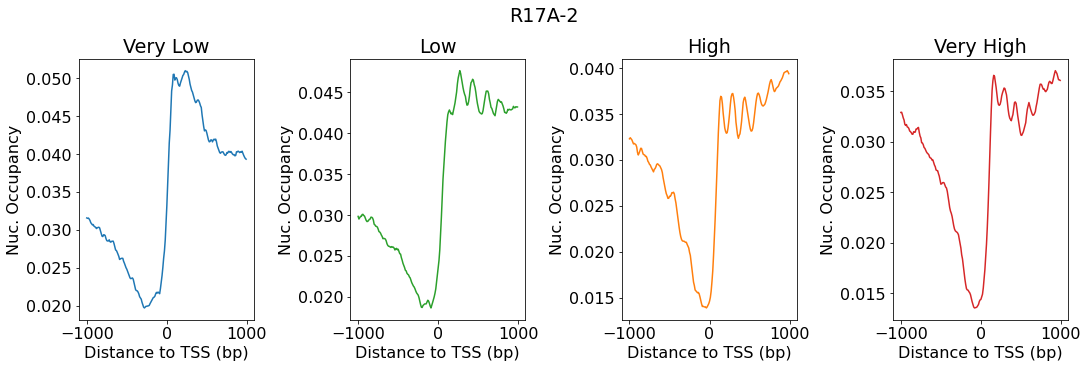

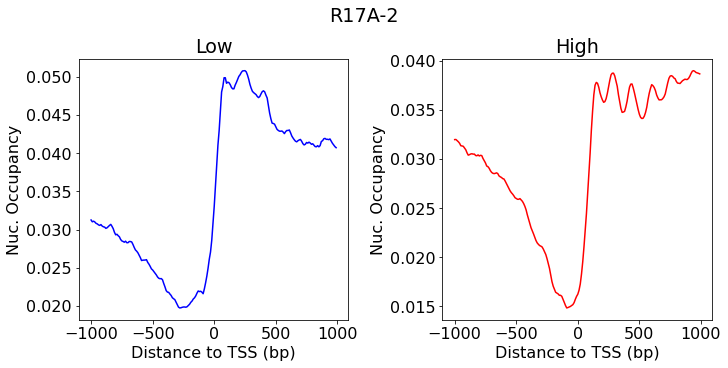

In [18]:
R17A2_4subset = tpm_expression_4groups(metadata, R17A_tpm, "R17A-2.merge.140-160","R17A-2.merge.140-160.199", "R17A-2")
R17A2_2subset = tpm_expression_2groups(metadata, R17A_tpm, "R17A-2.merge.140-160","R17A-2.merge.140-160.199", "R17A-2")

In [19]:
# Load DEG data
def deg_load(path, name):
    deg_file = pd.read_csv(path_to_file, sep='\t', header=None)
    deg_file.columns = [name]
    return deg_file

base_path = "/Users/emmacorcoran/Documents/R Scripts/RNA-seq/2020_10_02 RNA-seq/"

#chr11/17 down-regulated genes
filename = "chr_downreg.txt"
path_to_file = os.path.join(base_path, filename)
chr_downreg = deg_load(path_to_file, "gene name")

#chr11/17 up-regulated genes
filename = "chr_upreg.txt"
path_to_file = os.path.join(base_path, filename)
chr_upreg = deg_load(path_to_file, "gene name")

#R17A down-regulated genes
filename = "R17A_downreg.txt"
path_to_file = os.path.join(base_path, filename)
R17A_downreg = deg_load(path_to_file, "gene name")

#R17A up-regulated genes
filename = "R17A_upreg.txt"
path_to_file = os.path.join(base_path, filename)
R17A_upreg = deg_load(path_to_file, "gene name")

In [20]:
#Function to add labels corresponding to whether a gene is up- or down-regulated and combine up-reg and down-reg dfs
def add_deglabs(upreg, downreg):
    upreg['DEG'] = "up"
    downreg['DEG'] = "down"
    return upreg.append(downreg)

In [21]:
#Merge metadata with DEG data
chr_downreg_subset = pd.merge(metadata, chr_downreg, on="gene name")
chr_upreg_subset = pd.merge(metadata, chr_upreg, on="gene name")
chr_deg_subset = add_deglabs(chr_upreg_subset, chr_downreg_subset)
R17A_downreg_subset = pd.merge(metadata, R17A_downreg, on="gene name")
R17A_upreg_subset = pd.merge(metadata, R17A_upreg, on="gene name")
R17A_deg_subset = add_deglabs(R17A_upreg_subset, R17A_downreg_subset)
R17A_deg_subset

,Col-1.merge.140-160,Col-1.merge.140-160.1,Col-1.merge.140-160.2,Col-1.merge.140-160.3,Col-1.merge.140-160.4,Col-1.merge.140-160.5,Col-1.merge.140-160.6,Col-1.merge.140-160.7,Col-1.merge.140-160.8,Col-1.merge.140-160.9,...,R17A-2.merge.140-160.193,R17A-2.merge.140-160.194,R17A-2.merge.140-160.195,R17A-2.merge.140-160.196,R17A-2.merge.140-160.197,R17A-2.merge.140-160.198,R17A-2.merge.140-160.199,gene name,classification,DEG
0,0.03266,0.022650,0.014400,0.01053,0.008603,0.001405,0.000000,0.000000,0.000000,0.000000,...,0.053250,0.038880,0.029160,0.038670,0.060540,0.060740,0.05345,AT1G01120,protein_coding,up
1,0.01053,0.017730,0.038800,0.04214,0.038980,0.024400,0.003336,0.010010,0.036870,0.046350,...,0.004050,0.004050,0.008707,0.013160,0.012150,0.019030,0.01559,AT1G01130,protein_coding,up
2,0.02739,0.010180,0.010710,0.01615,0.035470,0.066890,0.066020,0.058120,0.054080,0.024400,...,0.033810,0.049000,0.048190,0.037460,0.046570,0.070460,0.08362,AT1G01180,protein_coding,up
3,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002458,...,0.044550,0.031180,0.004859,0.000000,0.000000,0.000607,0.00405,AT1G01610,protein_coding,up
4,0.06654,0.075150,0.082700,0.09516,0.104500,0.098150,0.092180,0.077780,0.062680,0.047760,...,0.077950,0.048590,0.047780,0.029560,0.008099,0.013970,0.08200,AT1G02205,protein_coding,up
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,0.08480,0.071280,0.054430,0.02915,0.035470,0.053900,0.067250,0.056010,0.072860,0.076380,...,0.075120,0.068840,0.056490,0.057100,0.040500,0.036040,0.04961,AT5G65970,protein_coding,down
686,0.03863,0.027210,0.029320,0.03371,0.046350,0.056890,0.085680,0.094640,0.076550,0.083400,...,0.029160,0.038880,0.081600,0.130000,0.134000,0.143800,0.13490,AT5G66600,protein_coding,down
687,0.04547,0.034760,0.024580,0.02405,0.020540,0.017560,0.022300,0.018790,0.007199,0.007023,...,0.008099,0.005264,0.000000,0.006074,0.017210,0.028350,0.04657,AT5G66640,protein_coding,down
688,0.05127,0.052670,0.053550,0.04899,0.004916,0.003512,0.002634,0.000000,0.000000,0.000000,...,0.043530,0.067430,0.092940,0.116800,0.132600,0.122700,0.13080,AT5G67200,protein_coding,down


In [22]:
def plot_gene_group(all_data, name):
    #Merge metadata with tpm expression data and subset for one sample
    subset_data = all_data.drop(['gene name', 'classification', 'DEG'],axis=1)
    #Sum rows
    nrow = all_data.shape[0]
    rowsum = np.array(subset_data.sum(axis=0))/nrow

    #Split data by sample
    Col_1_data = rowsum[0:200].tolist()
    H4WT_1_data = rowsum[200:400].tolist()
    R17A_1_data = rowsum[400:600].tolist()
    R17A_2_data = rowsum[600:800].tolist()
    
    #Plot data
    plt.rcParams.update({'font.size': 16})
    x_vals = np.arange(-1000,1000,10)
    fig, axs = plt.subplots(2, 2, constrained_layout=True)
    fig.set_size_inches(10, 10)
    for ax in axs.flat:
        ax.set(xlabel='Distance to TSS (bp)', ylabel='Nuc. Occupancy')
    axs[0, 0].plot(x_vals, Col_1_data)
    axs[0, 0].set_title('Col-1')

    axs[0, 1].plot(x_vals, H4WT_1_data)
    axs[0, 1].set_title('rH4-1')

    axs[1, 0].plot(x_vals, R17A_1_data)
    axs[1, 0].set_title('rH4R17A-1')

    axs[1, 1].plot(x_vals, R17A_2_data)
    axs[1, 1].set_title('rH4R17A-2')
    
    fig.suptitle(name)
    plt.savefig("/Users/emmacorcoran/Documents/Jupyter Code/2021_03_31_MNase/DEG_plots/merged_"+name)

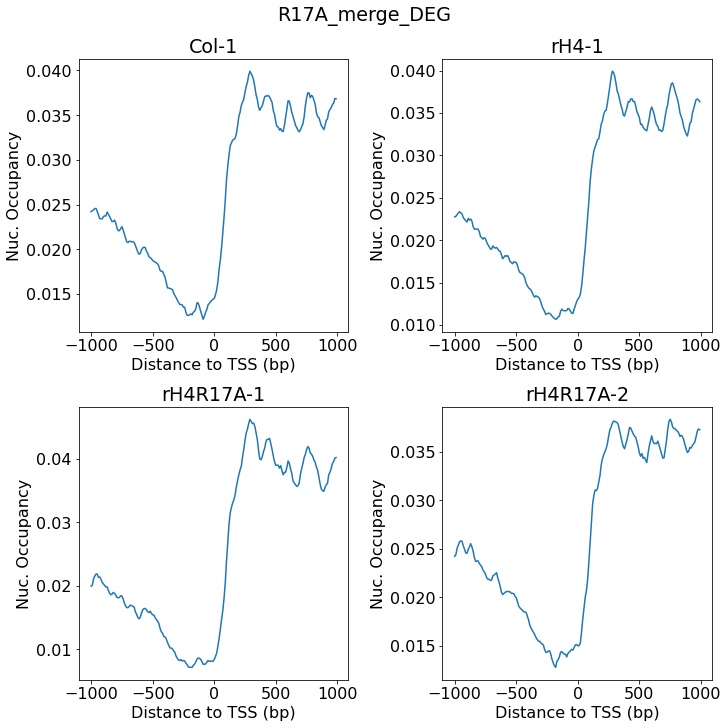

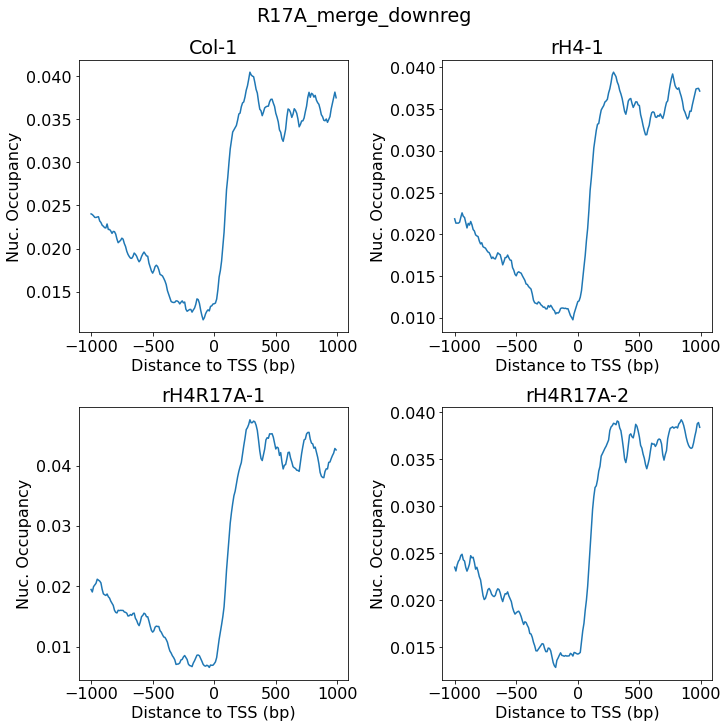

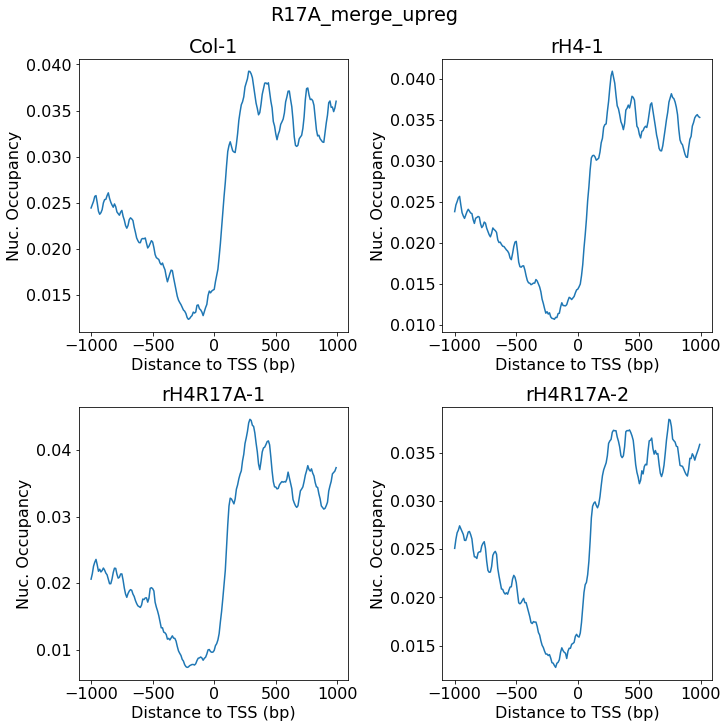

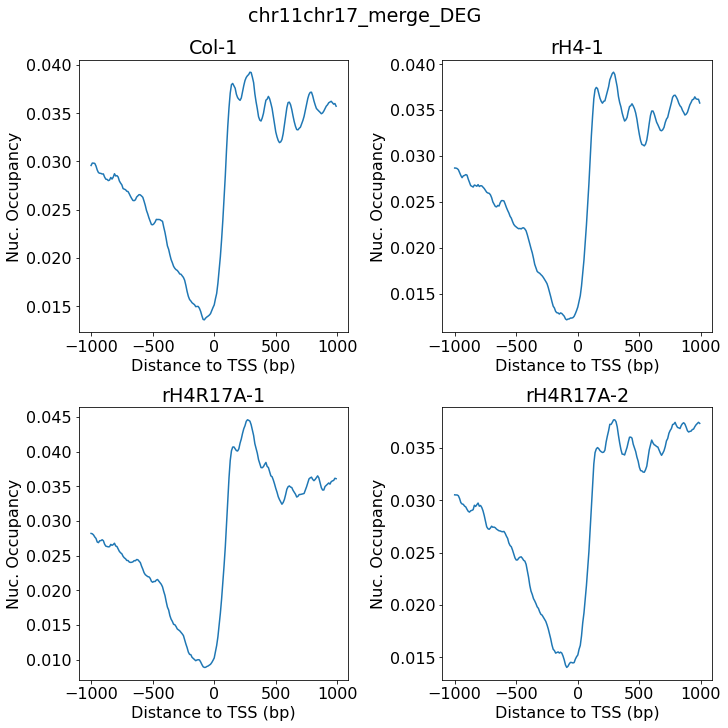

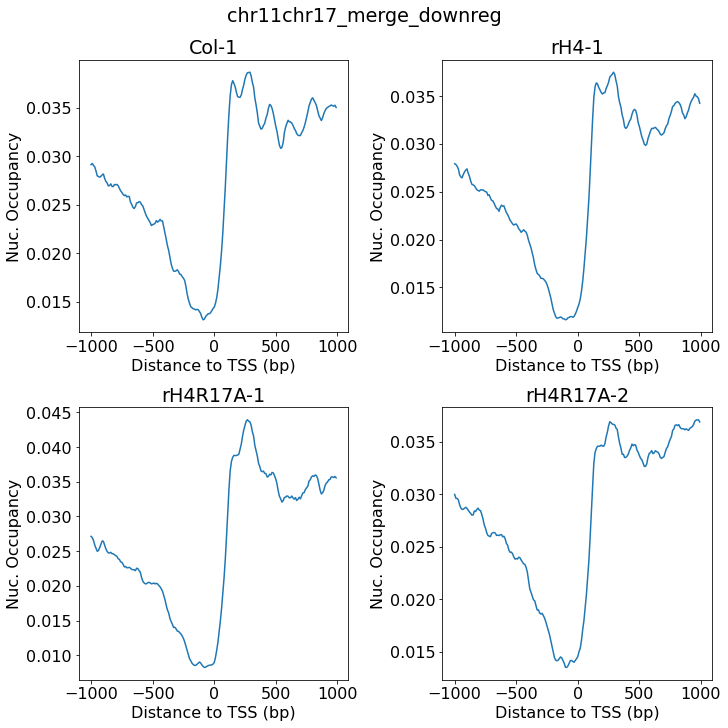

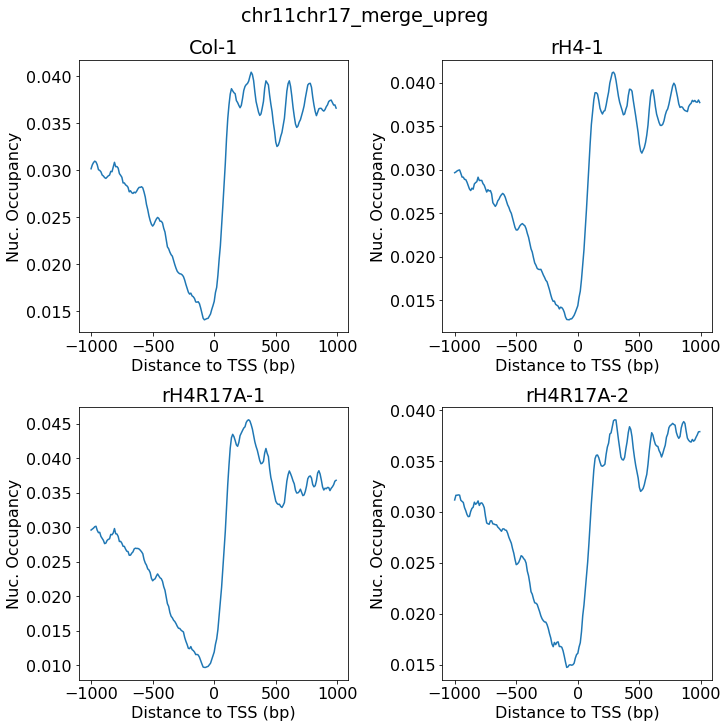

In [23]:
plot_gene_group(R17A_deg_subset, "R17A_merge_DEG")
plot_gene_group(R17A_downreg_subset, "R17A_merge_downreg")
plot_gene_group(R17A_upreg_subset, "R17A_merge_upreg")
plot_gene_group(chr_deg_subset, "chr11chr17_merge_DEG")
plot_gene_group(chr_downreg_subset, "chr11chr17_merge_downreg")
plot_gene_group(chr_upreg_subset, "chr11chr17_merge_upreg")

## Test Different Methods to Reduce Dimensionality and Cluster Data

### tSNE

In [24]:
#Function to get data and targets from data frame
def get_data_targets(df):
    # Separate out the features
    x = df.iloc[:,range(200)].values
    # Separate out the target
    y = df.loc[:,['expression']].values
    y_cat = df.loc[:,['expression category']].values
    # Standardize the features
    #x = StandardScaler().fit_transform(x)
    return x,y,y_cat

In [25]:
#Function to section data frame by gene subset
def subset_genes(df, subset_list):
    return pd.merge(subset_list.loc[:,'gene name'], df, on="gene name").drop(['gene name'],axis=1)

In [26]:
#Function to run tSNE
def run_tsne(x):
    # Convert to adjacency matrix
    adjmat = (np.dot(x, x.T) > 0).astype(int)
    # Remove self loop
    np.fill_diagonal(adjmat, 0)
    # Run tSNE
    tsne_embedded = TSNE(n_components=2, perplexity=30).fit_transform(adjmat)
    return tsne_embedded

In [27]:
#Function to perform tSNE on a data frame for each individual sample and plot
def tsne_4samples(df1, df2, df3, df4, name, subsample=True, gene_list=None):
    if subsample==True:
        #Subsample data down to 2000 randomly selected genes to make computations feasible on laptop
        subsample_1, subsample_2, subsample_3, subsample_4, = scprep.select.subsample(df1,df2,df3,df4,n=2000)
    else:
        #Use gene_list to subsection data
        subsample_1 = subset_genes(df1, gene_list)
        subsample_2 = subset_genes(df2, gene_list)
        subsample_3 = subset_genes(df3, gene_list)
        subsample_4 = subset_genes(df4, gene_list)
    
    #Get data and targets
    x1, y1, ycat1 = get_data_targets(subsample_1)
    x2, y2, ycat2 = get_data_targets(subsample_2)
    x3, y3, ycat3 = get_data_targets(subsample_3)
    x4, y4, ycat4 = get_data_targets(subsample_4)
    
    # Use tSNE for dimensionality reduction (takes about 10-15 min for 6000 genes)
    tsne_embedded_1 = run_tsne(x1)
    tsne_embedded_2 = run_tsne(x2)
    tsne_embedded_3 = run_tsne(x3)
    tsne_embedded_4 = run_tsne(x4)
    
    #Plot the data
    # Color by expression category
    fig, axs = plt.subplots(3, 3, constrained_layout=True)
    fig.set_size_inches(20, 15)
    plt.title(name)
    colors = {'very high':'crimson', 'high':'orange', 'low':'deepskyblue', 'very low':'darkblue'}
    # Plot tSNE scatter plots and label
    axs[0, 0].scatter(tsne_embedded_1[:,0], tsne_embedded_1[:,1], s=10, c=subsample_1['expression category'].map(colors))
    axs[0, 0].set_title('Col-1')
    axs[0, 1].scatter(tsne_embedded_2[:,0], tsne_embedded_2[:,1], s=10, c=subsample_2['expression category'].map(colors))
    axs[0, 1].set_title('rH4-1')
    axs[1, 0].scatter(tsne_embedded_3[:,0], tsne_embedded_3[:,1], s=10, c=subsample_3['expression category'].map(colors))
    axs[1, 0].set_title('rH4R17A-1')
    axs[1, 1].scatter(tsne_embedded_4[:,0], tsne_embedded_4[:,1], s=10, c=subsample_4['expression category'].map(colors))
    axs[1, 1].set_title('rH4R17A-2')
    
    #Add legend
    classes = ['very high', 'high', 'low', 'very low']
    class_colors = ['crimson', 'orange', 'deepskyblue', 'darkblue']
    recs = []
    for i in range(0,len(class_colors)):
        recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colors[i]))
    plt.legend(recs,classes,loc=4)
    plt.savefig("/Users/emmacorcoran/Documents/Jupyter Code/2021_03_31_MNase/tSNE/merged"+name)

In [28]:
#Random subset of genes
#tsne_4samples(Col1_4subset,H4WT1_4subset,R17A1_4subset,R17A2_4subset,"rand1_all",subsample=True)

In [29]:
#R17A DEGs
#tsne_4samples(Col1_4subset,H4WT1_4subset,R17A1_4subset,R17A2_4subset,name="R17A_DEG_4cat",subsample=False,gene_list=R17A_deg_subset)

In [30]:
#chr11/17 down-regulated genes
#tsne_4samples(Col1_4subset,H4WT1_4subset,R17A1_4subset,R17A2_4subset,name="chr_downreg_4cat",subsample=False,gene_list=chr_downreg_subset)
#chr11/17 up-regulated genes
#tsne_4samples(Col1_4subset,H4WT1_4subset,R17A1_4subset,R17A2_4subset,name="chr_upreg_4cat",subsample=False,gene_list=chr_upreg_subset)

In [31]:
#Function to perform tSNE on a data frame for each individual sample and plot - separates by up- and down-regulated genes
def tsne_updown(df, name):
    #Subsection data frame by sample
    x1 = df.iloc[:,0:200]
    x2 = df.iloc[:,200:400]
    x3 = df.iloc[:,400:600]
    x4 = df.iloc[:,600:800]
    
    # Use tSNE for dimensionality reduction (takes about 10-15 min for 6000 genes)
    tsne_embedded_1 = run_tsne(x1)
    tsne_embedded_2 = run_tsne(x2)
    tsne_embedded_3 = run_tsne(x3)
    tsne_embedded_4 = run_tsne(x4)
    
    #Plot the data
    # Color by expression category
    fig, axs = plt.subplots(3, 3, constrained_layout=True)
    fig.set_size_inches(20, 15)
    plt.title(name)
    colors = {'up':'crimson', 'down':'deepskyblue'}
    # Plot tSNE scatter plots and label
    axs[0, 0].scatter(tsne_embedded_1[:,0], tsne_embedded_1[:,1], s=10, c=df['DEG'].map(colors))
    axs[0, 0].set_title('Col-1')
    axs[0, 1].scatter(tsne_embedded_2[:,0], tsne_embedded_2[:,1], s=10, c=df['DEG'].map(colors))
    axs[0, 1].set_title('rH4-1')
    axs[1, 0].scatter(tsne_embedded_3[:,0], tsne_embedded_3[:,1], s=10, c=df['DEG'].map(colors))
    axs[1, 0].set_title('rH4R17A-1')
    axs[1, 1].scatter(tsne_embedded_4[:,0], tsne_embedded_4[:,1], s=10, c=df['DEG'].map(colors))
    axs[1, 1].set_title('rH4R17A-2')
    
    #Add legend
    classes = ['up', 'down']
    class_colors = ['crimson','deepskyblue']
    recs = []
    for i in range(0,len(class_colors)):
        recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colors[i]))
    plt.legend(recs,classes,loc=4)
    plt.savefig("/Users/emmacorcoran/Documents/Jupyter Code/2021_03_31_MNase/tSNE/merged-"+name)

In [32]:
#R17A DEGs - separated into up- and down-reg
#tsne_updown(R17A_deg_subset,"R17A-deg")

In [33]:
#chr11chr17 DEGs - separated into up- and down-reg
#tsne_updown(chr_deg_subset,"chr11chr17-deg")

### tSNE and k-means clustering

In [34]:
#Function to calculate average over all genes in a cluster
def rowsum_clusters(all_data, cluster_label):
    cluster_data = all_data.loc[all_data['cluster'] == cluster_label]
    cluster_data = cluster_data.iloc[:,0:200]
    nrow = cluster_data.shape[0]
    cluster_rowsum = np.array(cluster_data.sum(axis=0))/nrow
    return cluster_rowsum

In [35]:
7/8

0.875

In [36]:
#Function to plot nucleosome metaprofiles by cluster designation
def plot_cluster_profiles(subset_data, name):
    #Sum rows of different cluster groups
    rowsum_vals = []
    for i in range(8):
        rowsum_vals.append(rowsum_clusters(subset_data,i))
    
    #Produce nucleosome occupancy plots of tpm expression groups
    #Set parameters
    plt.rcParams.update({'font.size': 16})
    x_vals = np.arange(-1000,1000,10)
    fig, axs = plt.subplots(2, 4, constrained_layout=True)
    fig.set_size_inches(20, 10)
    
    #Set colors
    cmap = plt.cm.get_cmap('tab10')
    
    #Plot
    for ax in axs.flat:
        ax.set(xlabel='Distance to TSS (bp)', ylabel='Nuc. Occupancy')
    axs[0,0].plot(x_vals, rowsum_vals[0], c=cmap(0/7))
    axs[0,0].set_title('Cluster 0')
    axs[0,1].plot(x_vals, rowsum_vals[1], c=cmap(1/7))
    axs[0,1].set_title('Cluster 1')
    axs[0,2].plot(x_vals, rowsum_vals[2], c=cmap(2/7))
    axs[0,2].set_title('Cluster 2')
    axs[0,3].plot(x_vals, rowsum_vals[3], c=cmap(3/7))
    axs[0,3].set_title('Cluster 3')
    axs[1,0].plot(x_vals, rowsum_vals[4], c=cmap(4/7))
    axs[1,0].set_title('Cluster 4')
    axs[1,1].plot(x_vals, rowsum_vals[5], c=cmap(5/7))
    axs[1,1].set_title('Cluster 5')
    axs[1,2].plot(x_vals, rowsum_vals[6], c=cmap(6/7))
    axs[1,2].set_title('Cluster 6')
    axs[1,3].plot(x_vals, rowsum_vals[7], c=cmap(7/7))
    axs[1,3].set_title('Cluster 7')
    
    fig.suptitle(name)
    plt.savefig("/Users/emmacorcoran/Documents/Jupyter Code/2021_03_31_MNase/kmeans_profiles/merged"+name)

In [37]:
#Function to split DEG subsets into four samples
def split_deg_subset(df):
    #Subsection data frame by sample
    x1 = df.iloc[:,0:200]
    x1['DEG'] = df['DEG']
    x1['gene name'] = df['gene name']
    x2 = df.iloc[:,200:400]
    x2['DEG'] = df['DEG']
    x2['gene name'] = df['gene name']
    x3 = df.iloc[:,400:600]
    x3['DEG'] = df['DEG']
    x3['gene name'] = df['gene name']
    x4 = df.iloc[:,600:800]
    x4['DEG'] = df['DEG']
    x4['gene name'] = df['gene name']
    return x1, x2, x3, x4

In [39]:
#Split R17A deg subset into 4 samples
R17A_deg_Col1, R17A_deg_H4WT1, R17A_deg_R17A1, R17A_deg_R17A2 = split_deg_subset(R17A_deg_subset)
#Split chr11chr17 deg subset into 4 samples
chr_deg_Col1, chr_deg_H4WT1, chr_deg_R17A1, chr_deg_R17A2 = split_deg_subset(chr_deg_subset)

In [40]:
#Add expression data to DEG subsets
#R17A
R17A_deg_Col1 = pd.merge(R17A_deg_Col1, Col1_4subset.iloc[:,200:], on="gene name")
R17A_deg_H4WT1 = pd.merge(R17A_deg_H4WT1, H4WT1_4subset.iloc[:,200:], on="gene name")
R17A_deg_R17A1 = pd.merge(R17A_deg_R17A1, R17A1_4subset.iloc[:,200:], on="gene name")
R17A_deg_R17A2 = pd.merge(R17A_deg_R17A2, R17A2_4subset.iloc[:,200:], on="gene name")

In [41]:
#Add expression data to DEG subsets
#chr11/17
chr_deg_Col1 = pd.merge(chr_deg_Col1, Col1_4subset.iloc[:,200:], on="gene name")
chr_deg_H4WT1 = pd.merge(chr_deg_H4WT1, H4WT1_4subset.iloc[:,200:], on="gene name")
chr_deg_R17A1 = pd.merge(chr_deg_R17A1, R17A1_4subset.iloc[:,200:], on="gene name")
chr_deg_R17A2 = pd.merge(chr_deg_R17A2, R17A2_4subset.iloc[:,200:], on="gene name")

In [42]:
#Function to perform tSNE and run k-means on a data frame for each individual sample and plot
def tsne_kmeans_4samples(df1, df2, df3, df4, name='test', cluster_num=8, subsample=False):
    if subsample==True:
        #Subsample data down to 2000 randomly selected genes to make computations feasible on laptop
        df1, df2, df3, df4, = scprep.select.subsample(df1,df2,df3,df4,n=1200)
        x1 = df1.drop(columns=['gene name', 'expression', 'expression category'])
        x2 = df2.drop(columns=['gene name', 'expression', 'expression category'])
        x3 = df3.drop(columns=['gene name', 'expression', 'expression category'])
        x4 = df4.drop(columns=['gene name', 'expression', 'expression category'])
    else:
        x1 = df1.drop(columns=['DEG', 'gene name', 'expression', 'expression category'])
        x2 = df2.drop(columns=['DEG', 'gene name', 'expression', 'expression category'])
        x3 = df3.drop(columns=['DEG', 'gene name', 'expression', 'expression category'])
        x4 = df4.drop(columns=['DEG', 'gene name', 'expression', 'expression category'])

    # Use tSNE for dimensionality reduction (takes about 10-15 min for 6000 genes)
    tsne_embedded_1 = run_tsne(x1)
    tsne_embedded_2 = run_tsne(x2)
    tsne_embedded_3 = run_tsne(x3)
    tsne_embedded_4 = run_tsne(x4)
    
    # Performs k-means clustering on each sample
    kmeans_labels_subsample = KMeans(n_clusters=cluster_num).fit_predict(tsne_embedded_1)
    df1['cluster'] = kmeans_labels_subsample
    df2['cluster'] = kmeans_labels_subsample
    df3['cluster'] = kmeans_labels_subsample
    df4['cluster'] = kmeans_labels_subsample
    
    #Plot the data
    if subsample==False:
        plt.rcParams.update({'font.size': 22})
        #Color by up- or down-regulation
        fig, axs = plt.subplots(2, 2, constrained_layout=True)
        fig.set_size_inches(20, 15)
        plt.title(name)
        colors = {'up':'crimson', 'down':'deepskyblue'}
        # Plot tSNE scatter plots and label
        axs[0, 0].scatter(tsne_embedded_1[:,0], tsne_embedded_1[:,1], s=5, c=df1['DEG'].map(colors))
        axs[0, 0].set_title('Col-1', fontsize=30)
        axs[0, 1].scatter(tsne_embedded_2[:,0], tsne_embedded_2[:,1], s=5, c=df2['DEG'].map(colors))
        axs[0, 1].set_title('rH4-1', fontsize=30)
        axs[1, 0].scatter(tsne_embedded_3[:,0], tsne_embedded_3[:,1], s=5, c=df3['DEG'].map(colors))
        axs[1, 0].set_title('rH4R17A-1', fontsize=30)
        axs[1, 1].scatter(tsne_embedded_4[:,0], tsne_embedded_4[:,1], s=5, c=df4['DEG'].map(colors))
        axs[1, 1].set_title('rH4R17A-2', fontsize=30)
        #Add legend
        classes = ['up', 'down']
        class_colors = ['crimson','deepskyblue']
        recs = []
        for i in range(0,len(class_colors)):
            recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colors[i]))
        plt.legend(recs,classes,bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.savefig("/Users/emmacorcoran/Documents/Jupyter Code/2021_03_31_MNase/tSNE_updown/merged-"+name)
        
    # Color by expression label
    plt.rcParams.update({'font.size': 22})
    fig, axs = plt.subplots(2, 2, constrained_layout=True)
    fig.set_size_inches(20, 15)
    plt.title(name)
    colors = {'very high':'crimson', 'high':'orange', 'low':'deepskyblue', 'very low':'darkblue'}
    # Plot tSNE scatter plots and label
    axs[0, 0].scatter(tsne_embedded_1[:,0], tsne_embedded_1[:,1], s=5, c=df1['expression category'].map(colors))
    axs[0, 0].set_title('Col-1', fontsize=30)
    axs[0, 1].scatter(tsne_embedded_2[:,0], tsne_embedded_2[:,1], s=5, c=df2['expression category'].map(colors))
    axs[0, 1].set_title('rH4-1', fontsize=30)
    axs[1, 0].scatter(tsne_embedded_3[:,0], tsne_embedded_3[:,1], s=5, c=df3['expression category'].map(colors))
    axs[1, 0].set_title('rH4R17A-1', fontsize=30)
    axs[1, 1].scatter(tsne_embedded_4[:,0], tsne_embedded_4[:,1], s=5, c=df4['expression category'].map(colors))
    axs[1, 1].set_title('rH4R17A-2', fontsize=30)
    #Add legend
    classes = ['very high', 'high', 'low', 'very low']
    class_colors = ['crimson', 'orange', 'deepskyblue', 'darkblue']
    recs = []
    for i in range(0,len(class_colors)):
        recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colors[i]))
    plt.legend(recs,classes,bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.savefig("/Users/emmacorcoran/Documents/Jupyter Code/2021_03_31_MNase/tSNE_expression/merged-"+name)
    
    # Color by k-means cluster label
    plt.rcParams.update({'font.size': 22})
    fig, axs = plt.subplots(2, 2, constrained_layout=True)
    fig.set_size_inches(20, 15)
    plt.title(name)
    # Plot tSNE scatter plots and label
    axs[0, 0].scatter(tsne_embedded_1[:,0], tsne_embedded_1[:,1], s=5, c=kmeans_labels_subsample,cmap='tab10')
    axs[0, 0].set_title('Col-1', fontsize=30)
    axs[0, 1].scatter(tsne_embedded_2[:,0], tsne_embedded_2[:,1], s=5, c=kmeans_labels_subsample,cmap='tab10')
    axs[0, 1].set_title('rH4-1', fontsize=30)
    axs[1, 0].scatter(tsne_embedded_3[:,0], tsne_embedded_3[:,1], s=5, c=kmeans_labels_subsample,cmap='tab10')
    axs[1, 0].set_title('rH4R17A-1', fontsize=30)
    scatter = axs[1, 1].scatter(tsne_embedded_4[:,0], tsne_embedded_4[:,1], s=5, c=kmeans_labels_subsample,cmap='tab10')
    axs[1, 1].set_title('rH4R17A-2', fontsize=30)
    #Add legend
    legend1 = axs[1,1].legend(*scatter.legend_elements(), loc="lower right", title="Clusters", bbox_to_anchor=(1.2, 0.35))
    axs[1,1].add_artist(legend1)
    plt.savefig("/Users/emmacorcoran/Documents/Jupyter Code/2021_03_31_MNase/tSNE_kmeans/merged-"+name)
    
    # Plot metaprofiles of clusters
    plot_cluster_profiles(df1,"Col-1_"+name)
    plot_cluster_profiles(df2,"rH4-1_"+name)
    plot_cluster_profiles(df3,"rH4R17A-1_"+name)
    plot_cluster_profiles(df4,"rH4R17A-2_"+name)

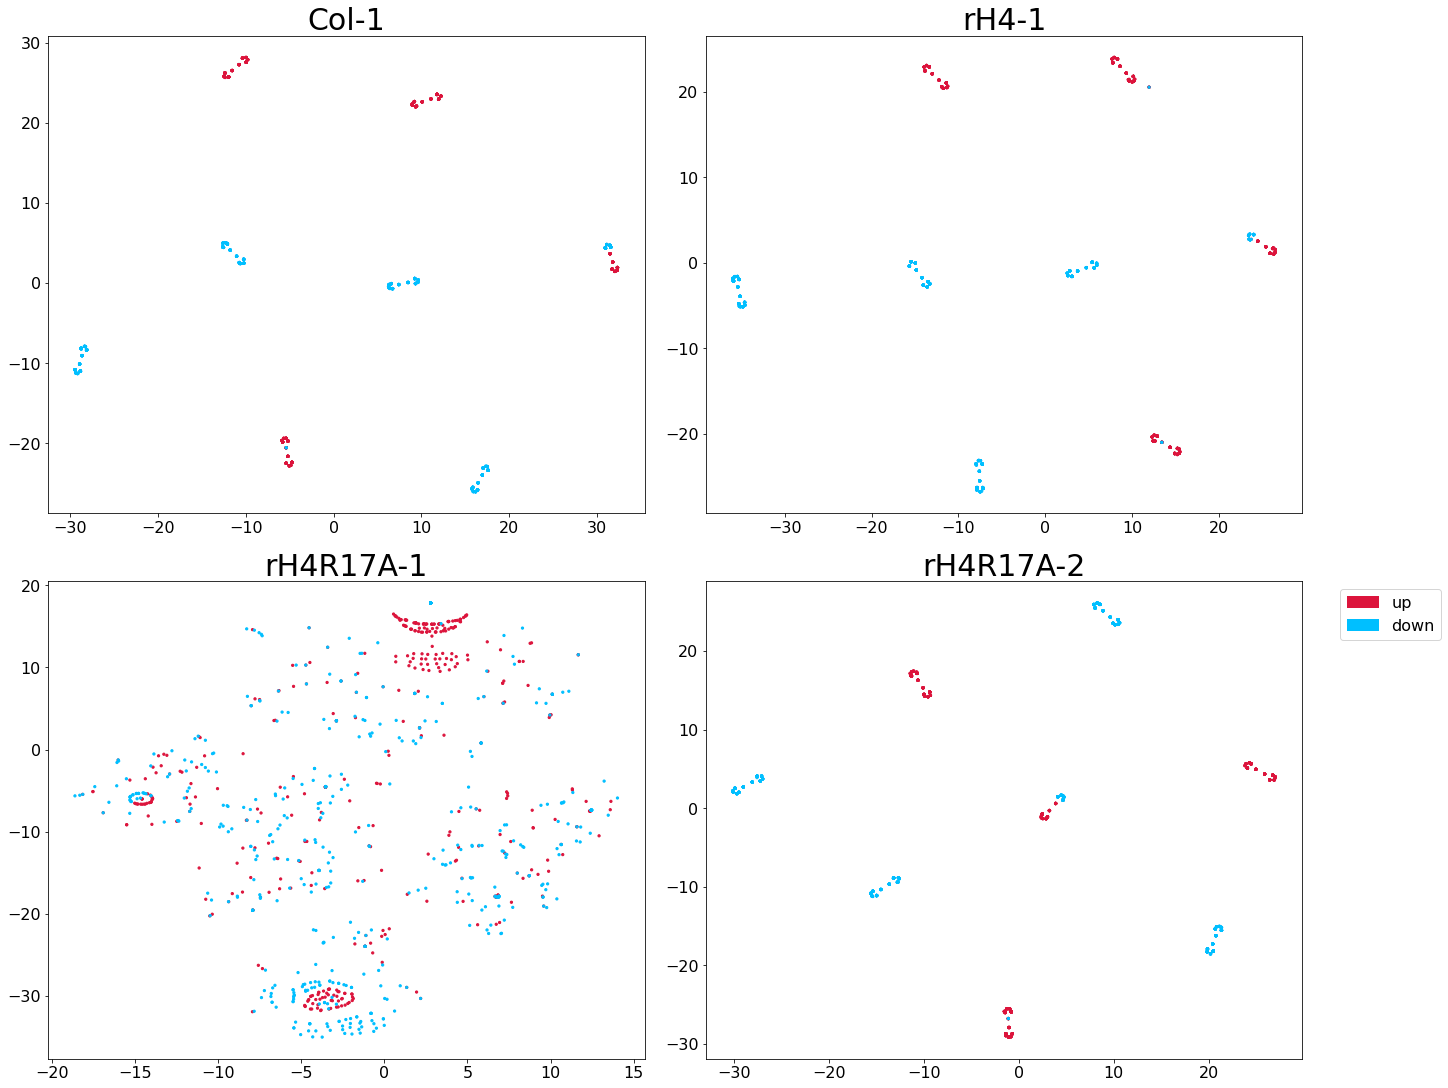

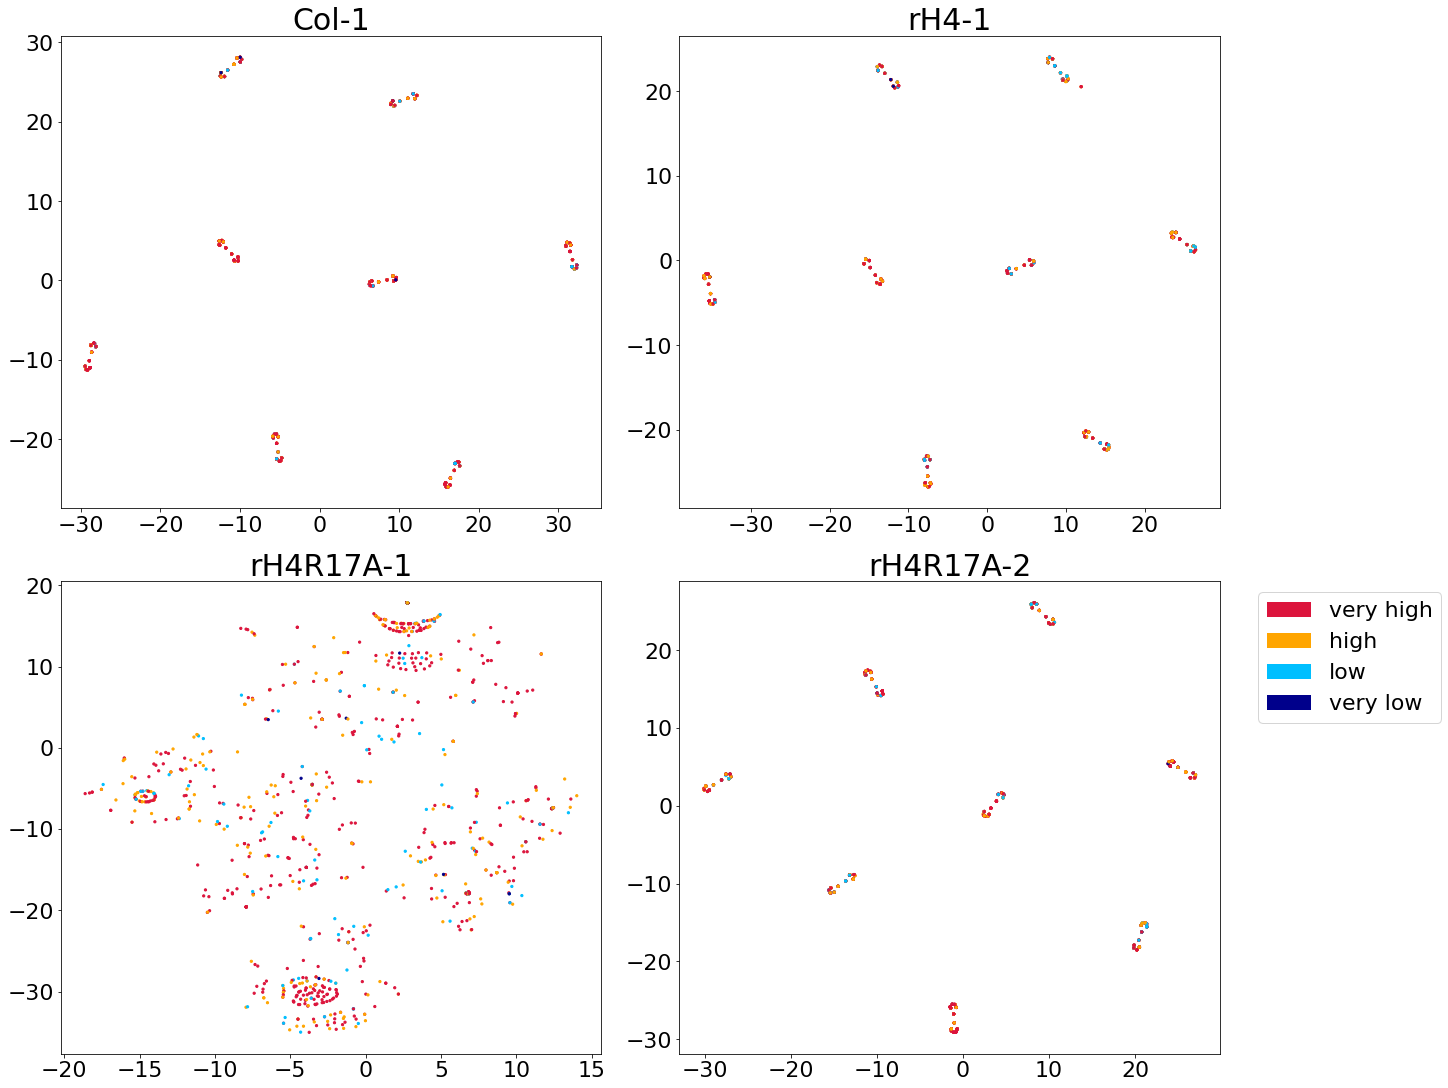

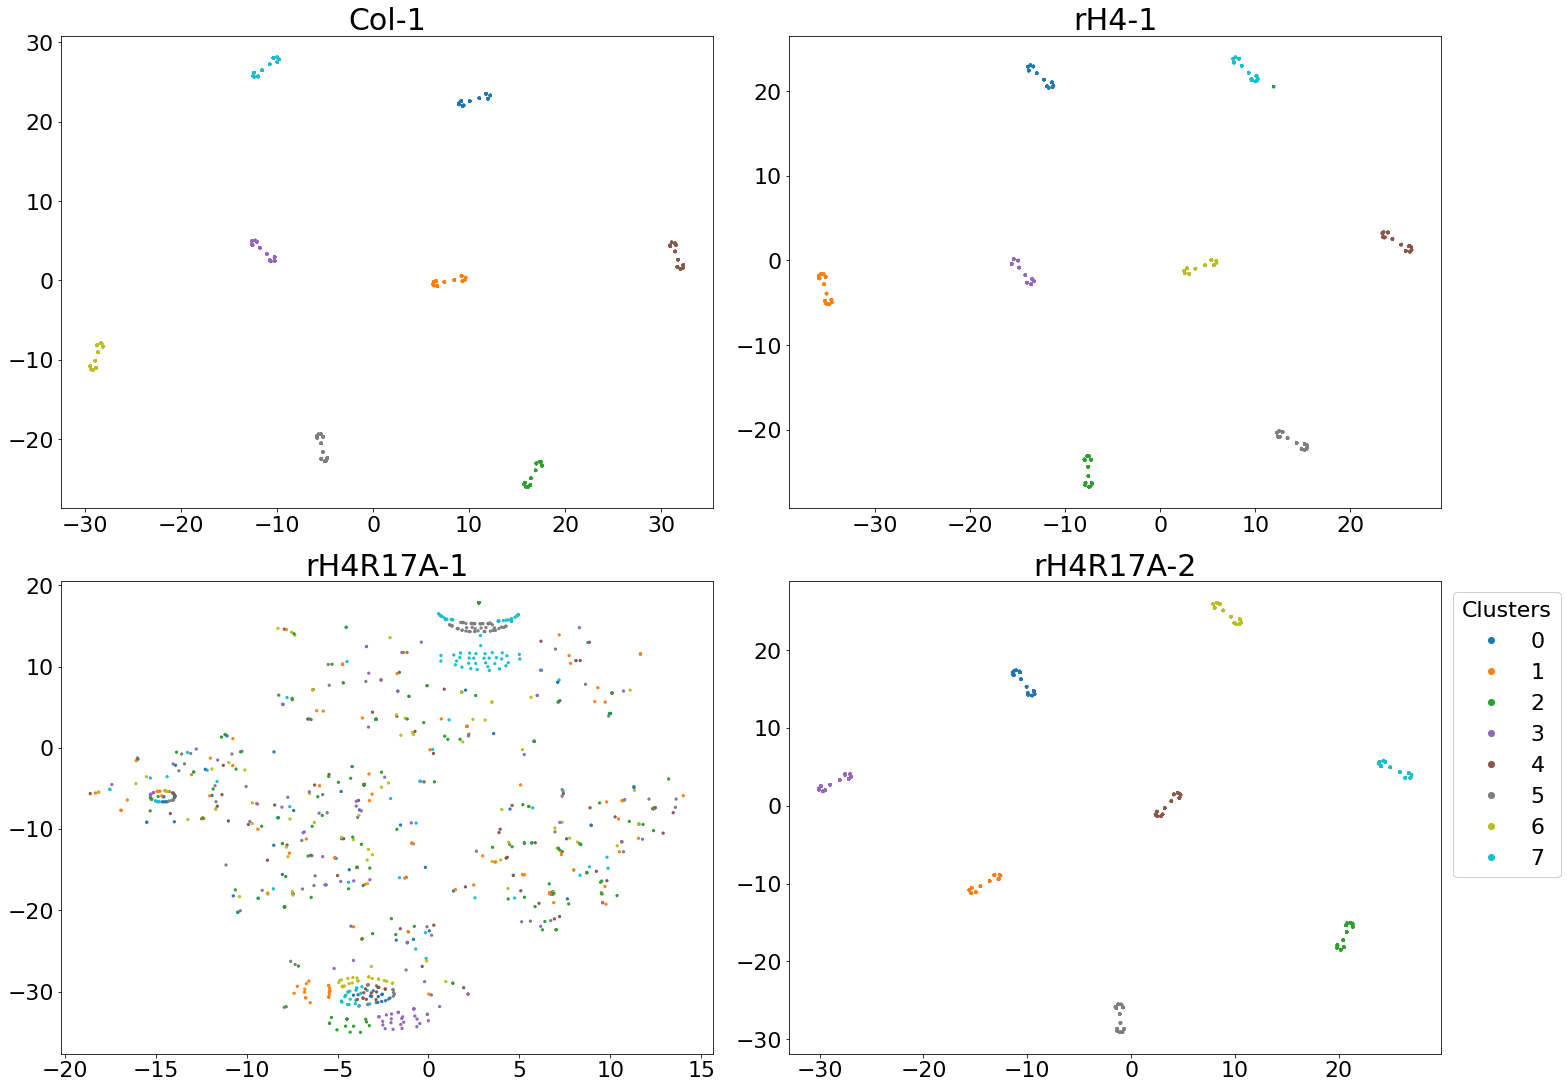

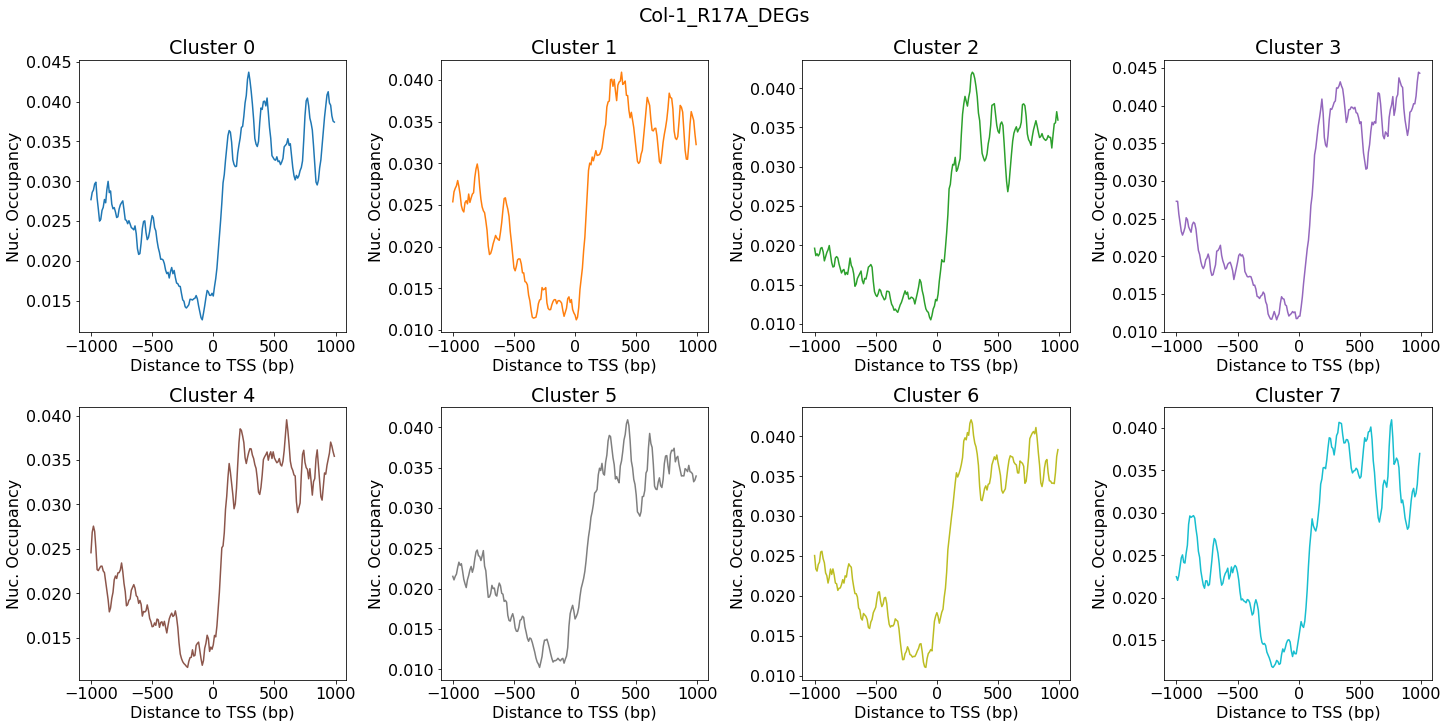

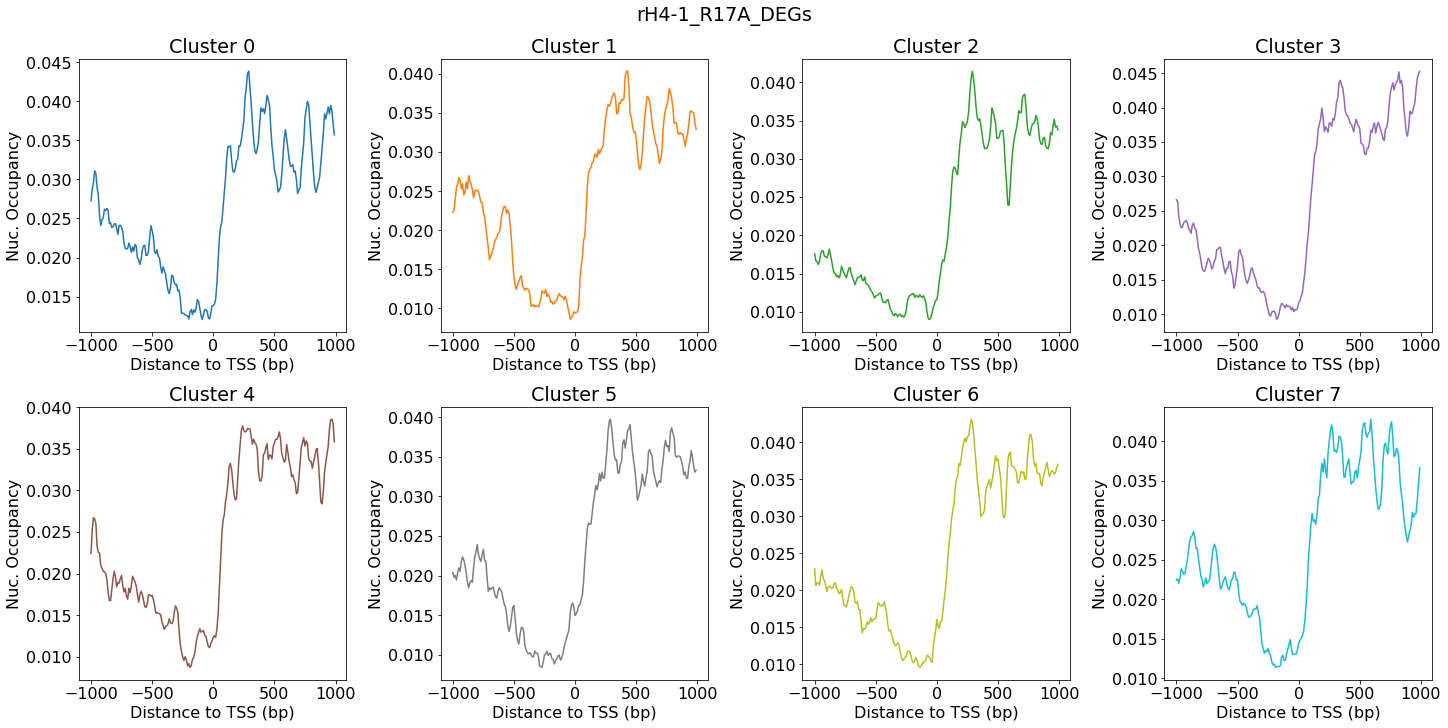

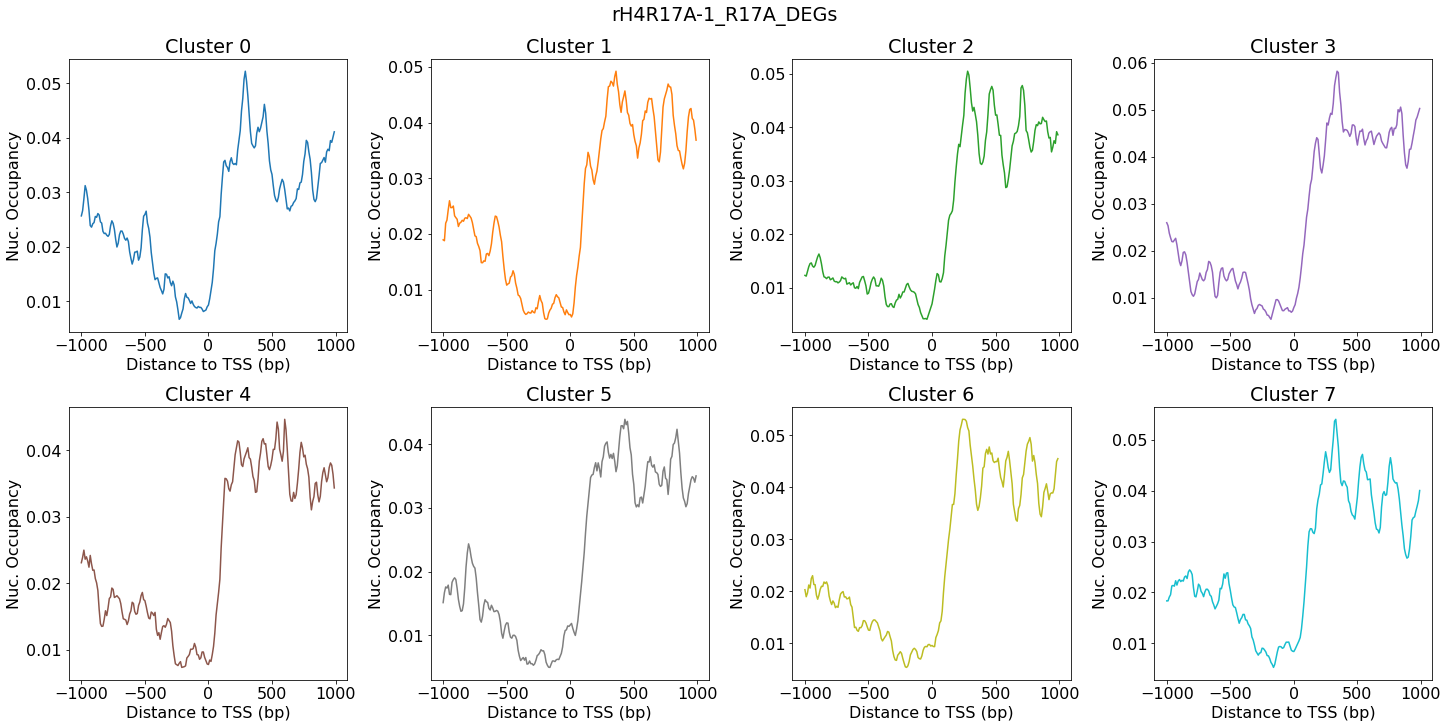

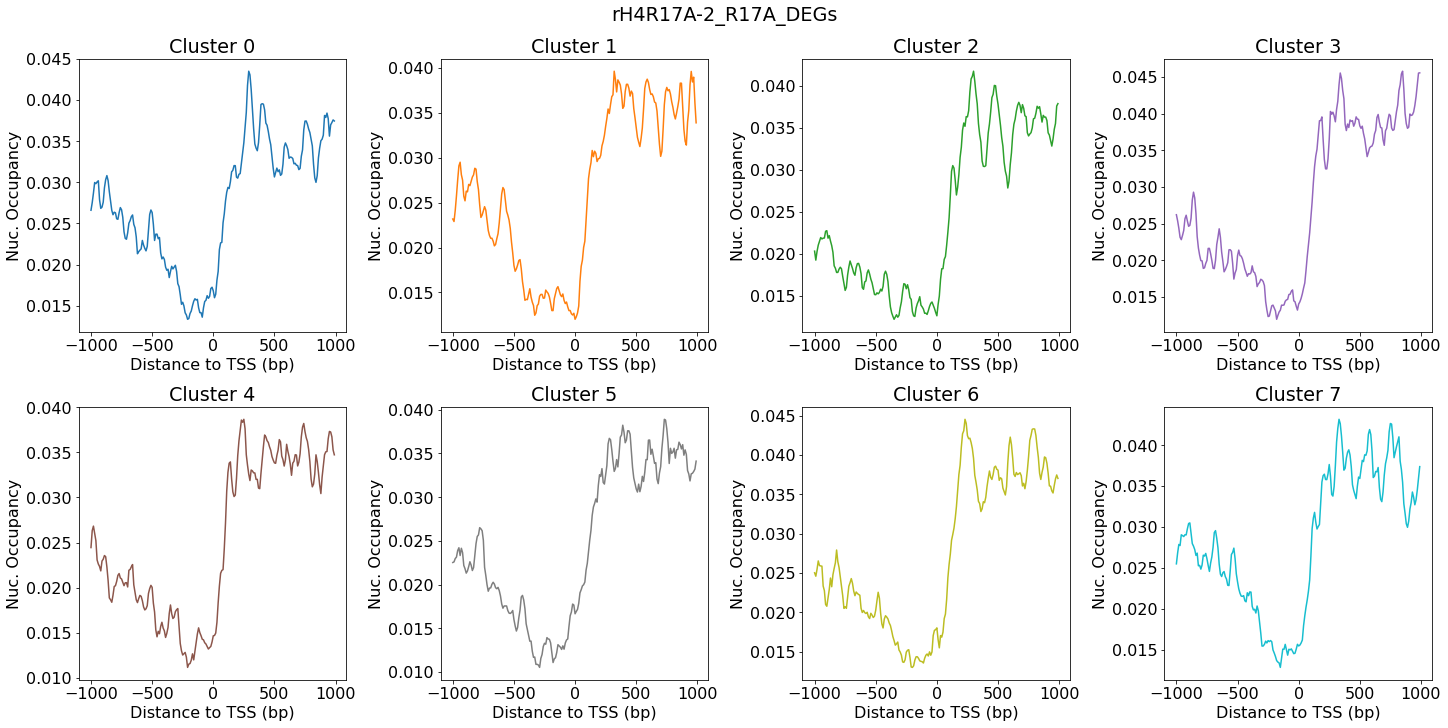

In [43]:
#Plot R17A DEGs
tsne_kmeans_4samples(R17A_deg_Col1, R17A_deg_H4WT1, R17A_deg_R17A1, R17A_deg_R17A2, name='R17A_DEGs', cluster_num=8)

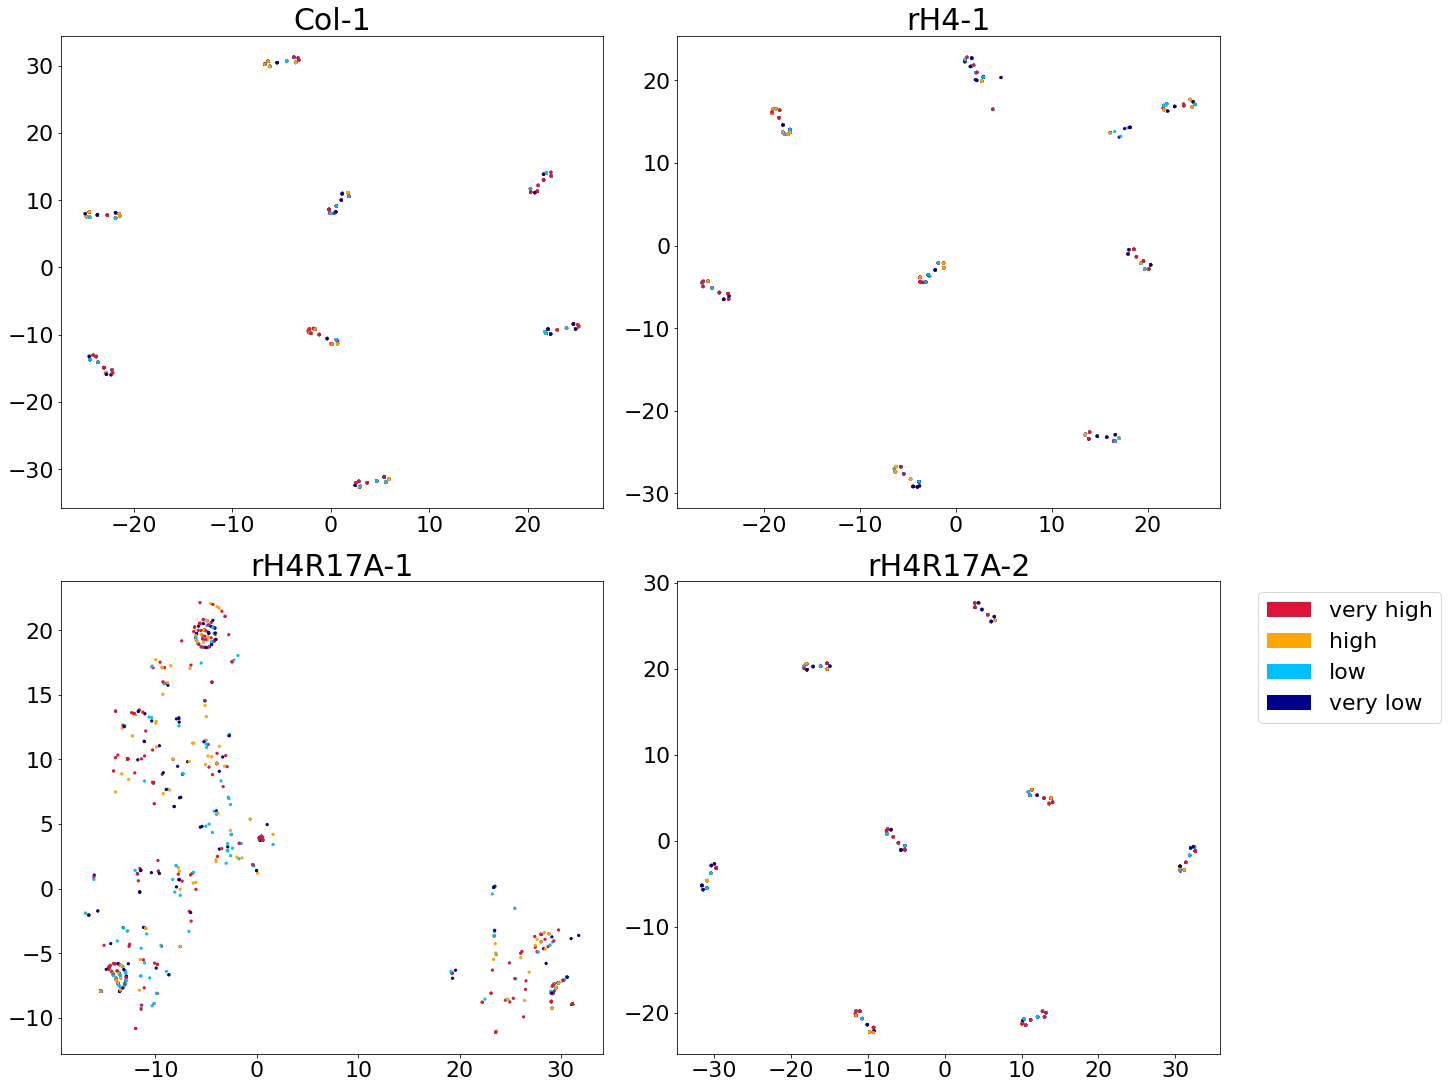

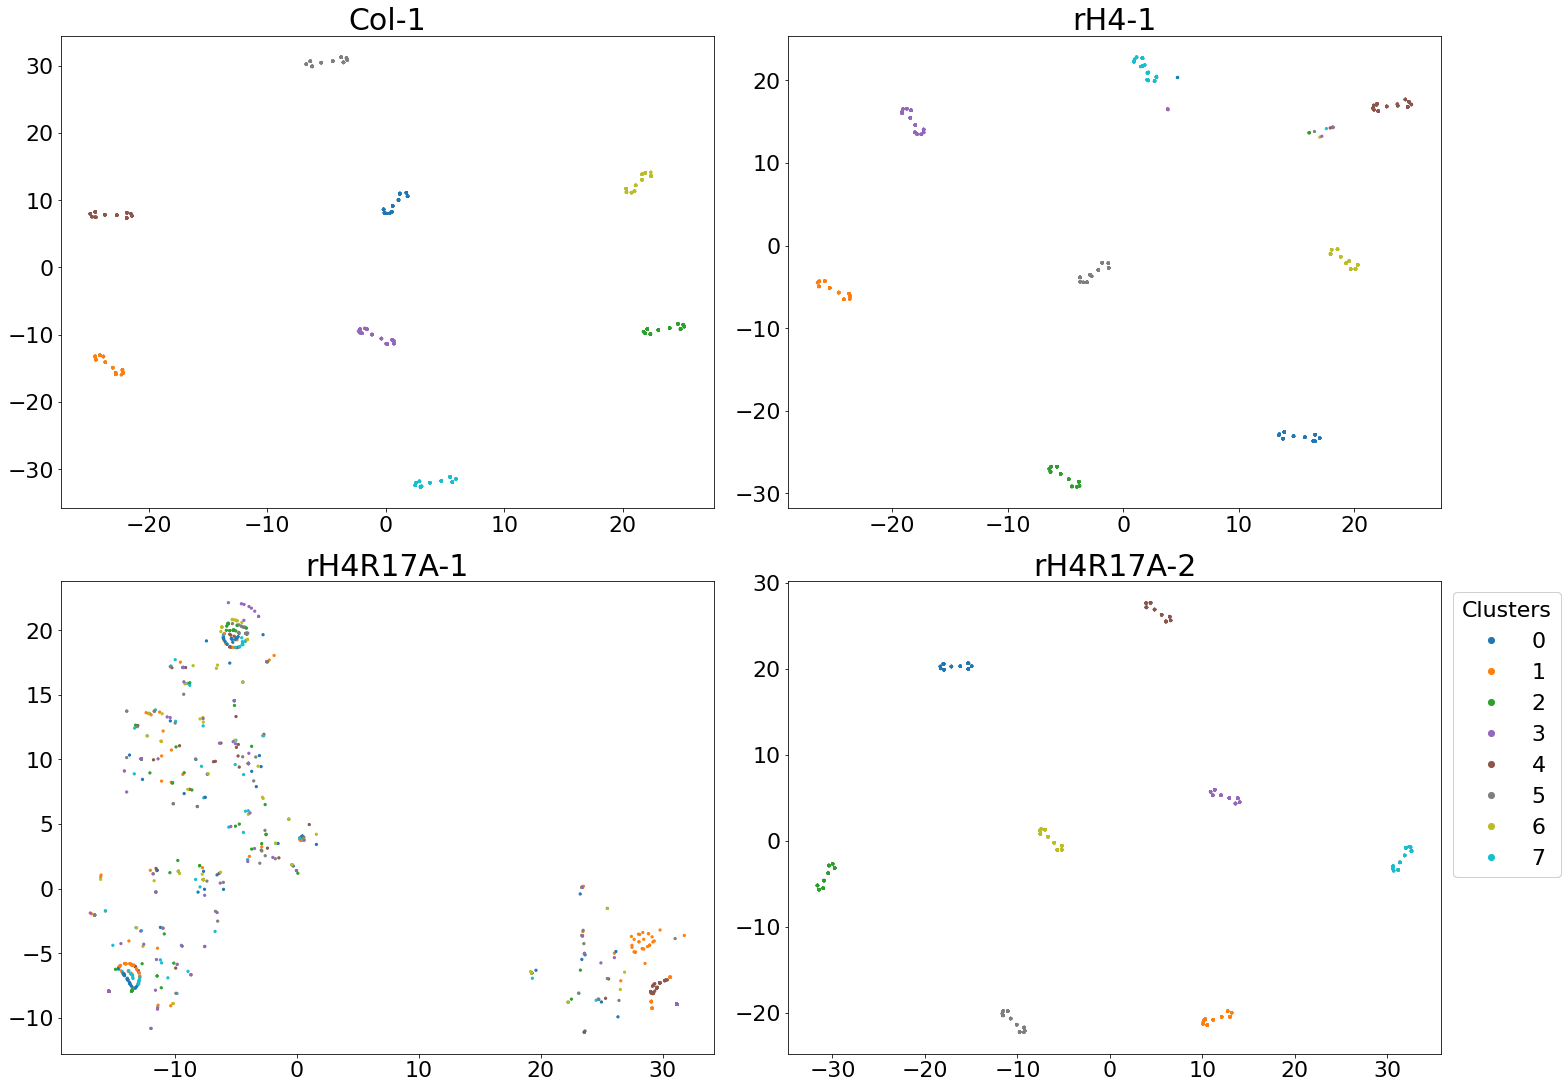

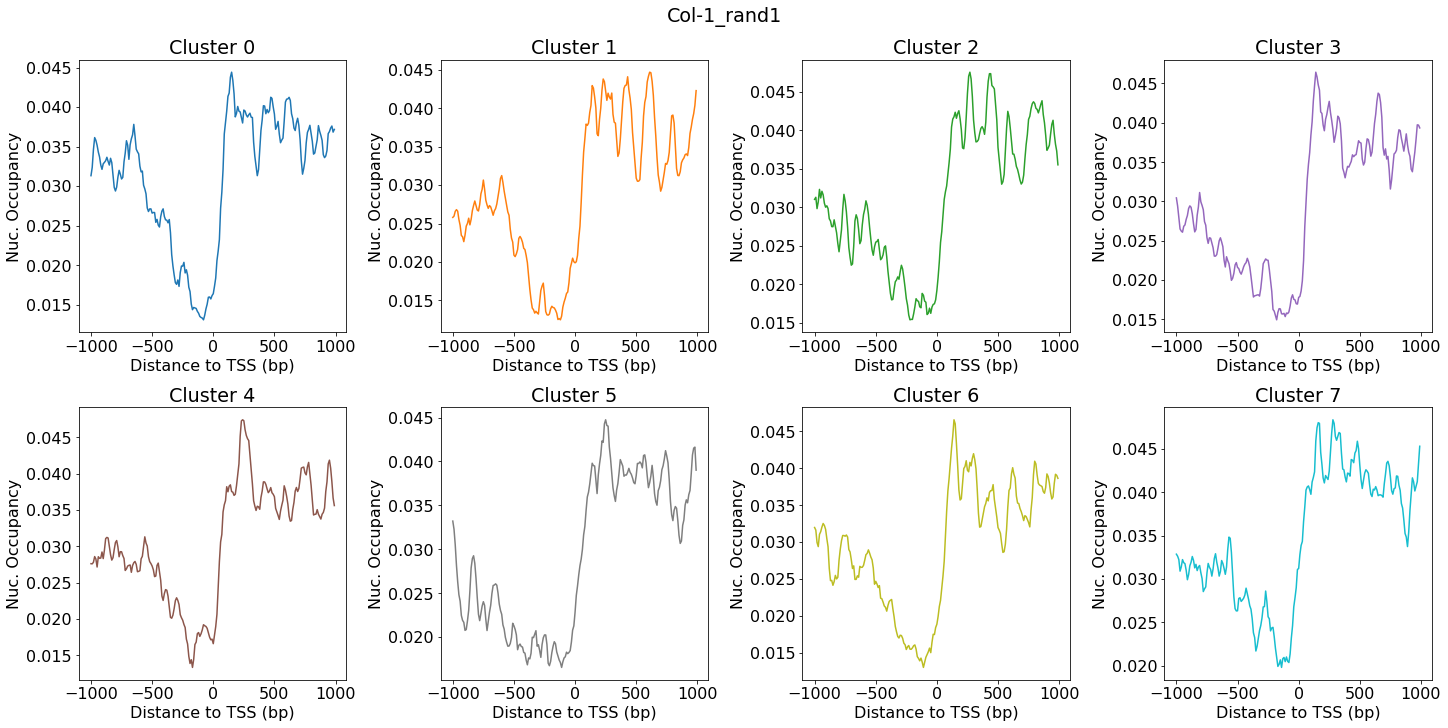

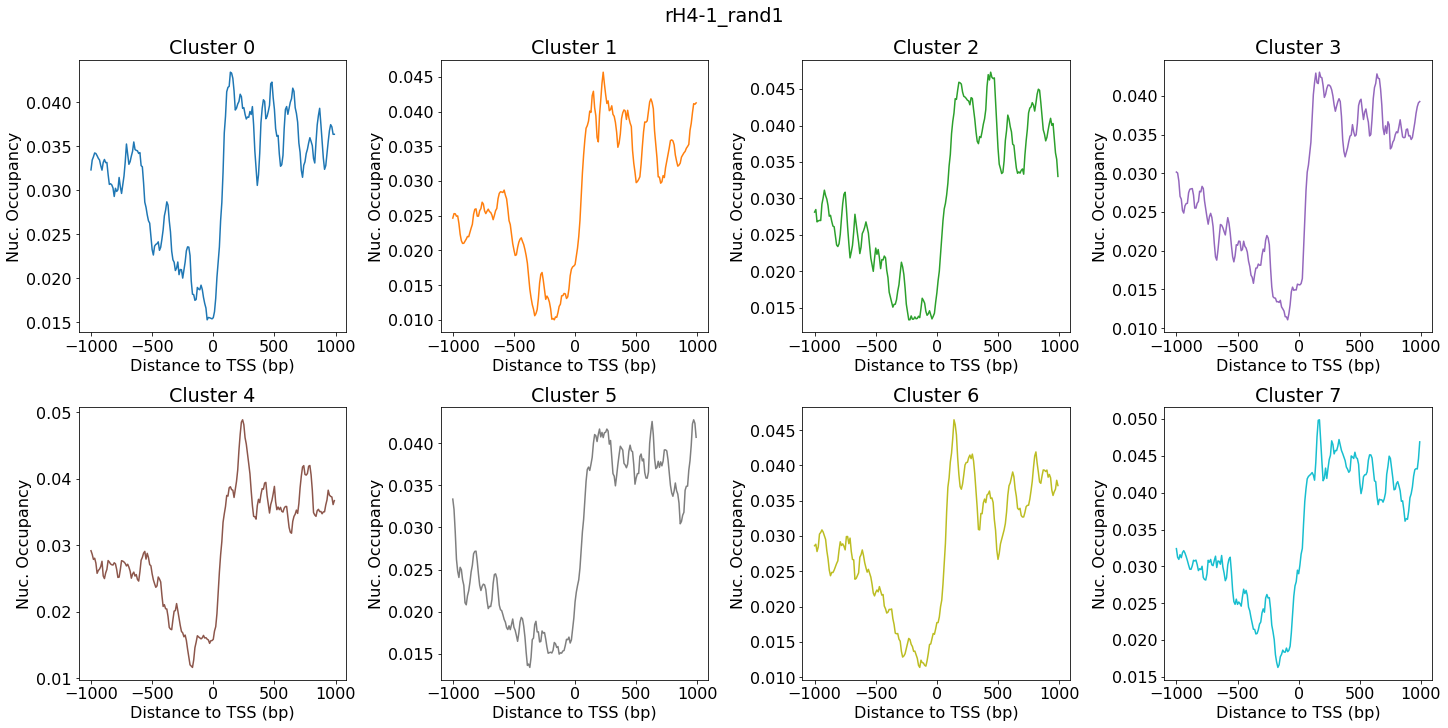

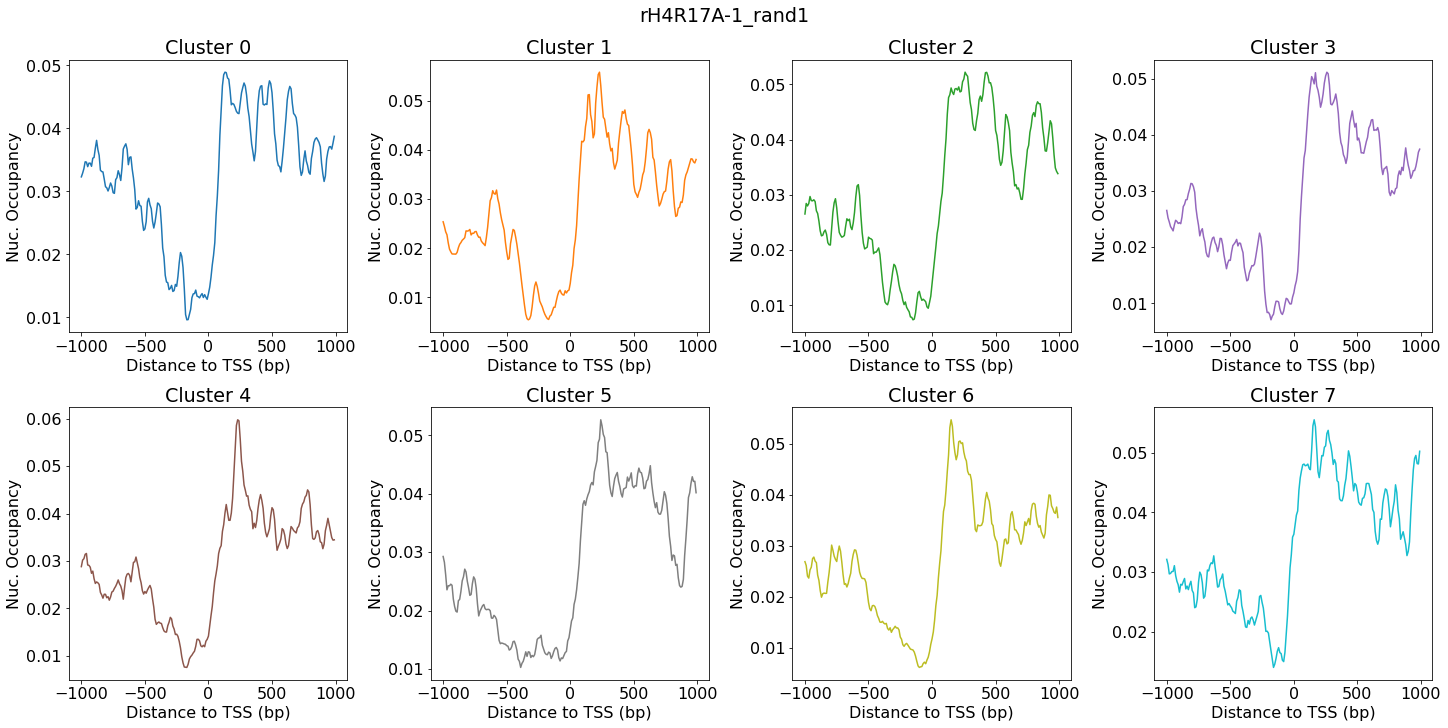

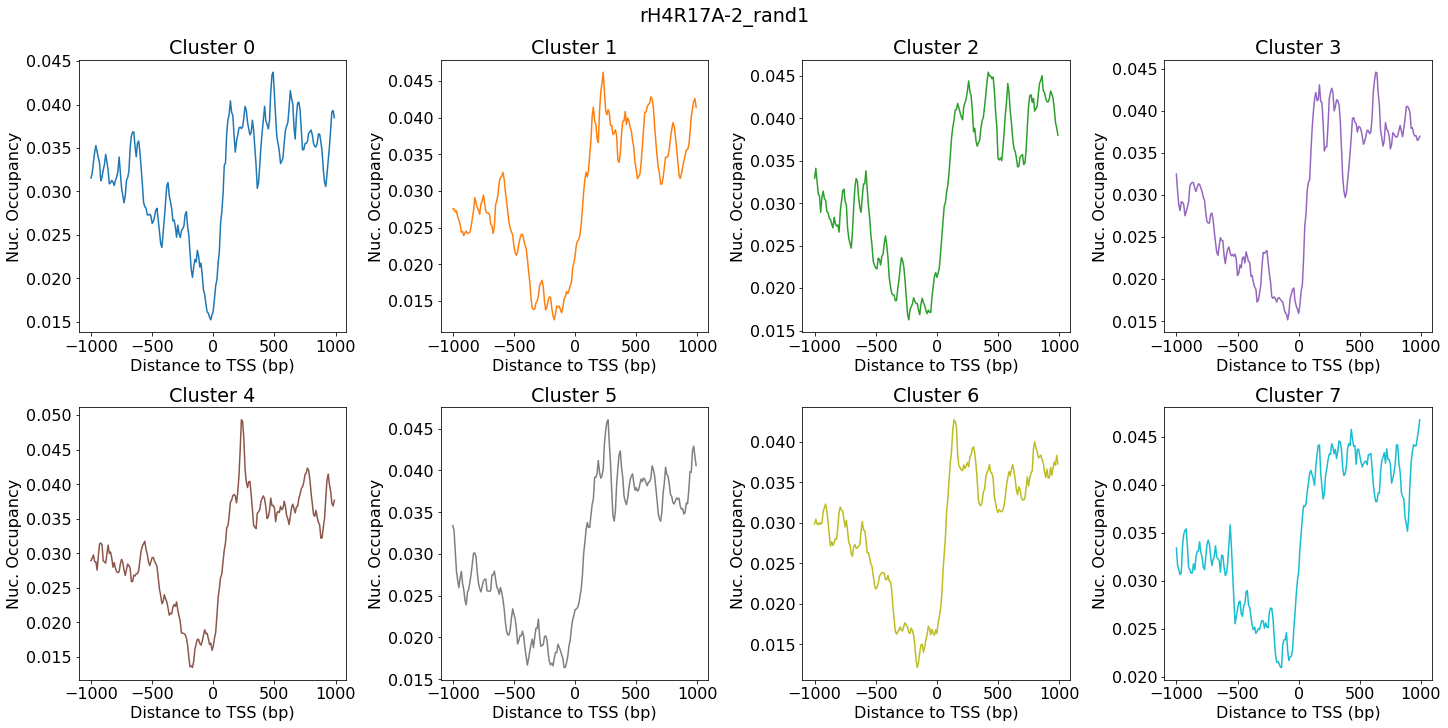

In [44]:
#Plot Random Sample
tsne_kmeans_4samples(Col1_4subset, H4WT1_4subset, R17A1_4subset, R17A2_4subset, name='rand1', cluster_num=8, subsample=True)

In [45]:
#Plot chr11/17 DEGs
tsne_kmeans_4samples(chr_deg_Col1, chr_deg_H4WT1, chr_deg_R17A1, chr_deg_R17A2, name='chr_DEGs', cluster_num=8)

KeyboardInterrupt: 